In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Load the dataset
file_path = "Food_Inspections_20250216.csv"  # Ensure the correct path
df = pd.read_csv(file_path, low_memory=False)

# Define known city names and common first names for domain classification
common_cities = {"New York", "Los Angeles", "Chicago", "Houston", "Phoenix"}  # Extend this list as needed
common_first_names = {"John", "Mary", "James", "Patricia", "Robert", "Jennifer"}  # Extend this list as needed

In [ ]:
# Function to determine the basic type
# test
def get_basic_type(value):
    if pd.isna(value):
        return "Missing"
    elif isinstance(value, (int, float, np.number)):
        return "Numeric"
    elif isinstance(value, str):
        if value.isdigit():
            return "Numeric"
        elif value.isalpha():
            return "Alphabetic"
        elif value.isalnum():
            return "Alphanumeric"
        try:
            datetime.strptime(value, "%Y-%m-%d")
            return "Date"
        except ValueError:
            try:
                datetime.strptime(value, "%H:%M:%S")
                return "Time"
            except ValueError:
                return "Text"
    return "Unknown"

# Function to determine value patterns
def detect_pattern(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    pattern = "".join(["9" if c.isdigit() else "A" if c.isupper() else "a" if c.islower() else "X" for c in value])
    return pattern

# Function to classify data class
def classify_data_class(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    if re.fullmatch(r"[A-Za-z0-9]+", value):
        return "Code/Identifier"
    elif re.fullmatch(r"\d+(\.\d+)?", value):
        return "Quantity"
    elif re.fullmatch(r"\d{4}-\d{2}-\d{2}", value) or re.fullmatch(r"\d{2}/\d{2}/\d{4}", value):
        return "Date/Time"
    elif re.fullmatch(r"[A-Za-z ]+", value):
        return "Text"
    return "Other"

# Function to classify domain
def classify_domain(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    if re.fullmatch(r"\d{16}", value):
        return "Credit Card Number"
    elif value in common_cities:
        return "City"
    elif value in common_first_names:
        return "Person Name"
    elif re.fullmatch(r"\d{5}(-\d{4})?", value):
        return "Postal Code"
    elif re.fullmatch(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}", value):
        return "Timestamp"
    return "Unknown"

In [7]:
basic_types_results = []
for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue
    
    # Determine basic types
    basic_types = col_data.map(get_basic_type).value_counts().to_dict()
    basic_types_results.append({
        "Column": column,
        "Basic Type": basic_types
    })

In [26]:
basic_types_results

[{'Column': 'Inspection ID', 'Basic Type': {'Numeric': 287237}},
 {'Column': 'DBA Name',
  'Basic Type': {'Text': 264513,
   'Alphabetic': 22573,
   'Alphanumeric': 138,
   'Numeric': 13}},
 {'Column': 'AKA Name',
  'Basic Type': {'Text': 257923,
   'Alphabetic': 26767,
   'Alphanumeric': 85,
   'Numeric': 36}},
 {'Column': 'License #', 'Basic Type': {'Numeric': 287219}},
 {'Column': 'Facility Type',
  'Basic Type': {'Alphabetic': 222203, 'Text': 59822, 'Numeric': 15}},
 {'Column': 'Risk', 'Basic Type': {'Text': 287081, 'Alphabetic': 68}},
 {'Column': 'Address', 'Basic Type': {'Text': 287237}},
 {'Column': 'City',
  'Basic Type': {'Alphabetic': 286986, 'Text': 81, 'Alphanumeric': 6}},
 {'Column': 'State', 'Basic Type': {'Alphabetic': 287179}},
 {'Column': 'Zip', 'Basic Type': {'Numeric': 287198}},
 {'Column': 'Inspection Date', 'Basic Type': {'Text': 287237}},
 {'Column': 'Inspection Type',
  'Basic Type': {'Alphabetic': 215245, 'Text': 71991}},
 {'Column': 'Results', 'Basic Type': {'A

In [10]:
dbms_type_results = []
for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue
   
    # Determine DBMS data type (assumed based on Python data types)
    dbms_type = df[column].dtype

    dbms_type_results.append({
        "Column": column,
        "DBMS Type": str(dbms_type),
    })


In [12]:
pd.DataFrame(dbms_type_results)

Column DBMS Type
0     Inspection ID     int64
1          DBA Name    object
2          AKA Name    object
3         License #   float64
4     Facility Type    object
5              Risk    object
6           Address    object
7              City    object
8             State    object
9               Zip   float64
10  Inspection Date    object
11  Inspection Type    object
12          Results    object
13       Violations    object
14         Latitude   float64
15        Longitude   float64
16         Location    object

In [13]:
# Profiling results
size_results = []

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue
    
    # Determine max size in digits and decimals (for numeric values)
    numeric_values = pd.to_numeric(col_data, errors='coerce').dropna()
    max_size = numeric_values.map(lambda x: len(str(int(x))) if not pd.isna(x) else 0).max() if not numeric_values.empty else None
    max_decimals = numeric_values.map(lambda x: len(str(x).split(".")[-1]) if '.' in str(x) else 0).max() if not numeric_values.empty else None

    size_results.append({
        "Column": column,
        "Max Digits": max_size,
        "Max Decimals": max_decimals
    })


In [15]:
pd.DataFrame(size_results)

Column  Max Digits  Max Decimals
0     Inspection ID         7.0           0.0
1          DBA Name         6.0           1.0
2          AKA Name         4.0           1.0
3         License #         7.0           1.0
4     Facility Type         4.0           1.0
5              Risk         NaN           NaN
6           Address         NaN           NaN
7              City         NaN           NaN
8             State         NaN           NaN
9               Zip         5.0           1.0
10  Inspection Date         NaN           NaN
11  Inspection Type         NaN           NaN
12          Results         NaN           NaN
13       Violations         NaN           NaN
14         Latitude         2.0          15.0
15        Longitude         3.0          14.0
16         Location         NaN           NaN

Histograms saved in column_pattern_histograms


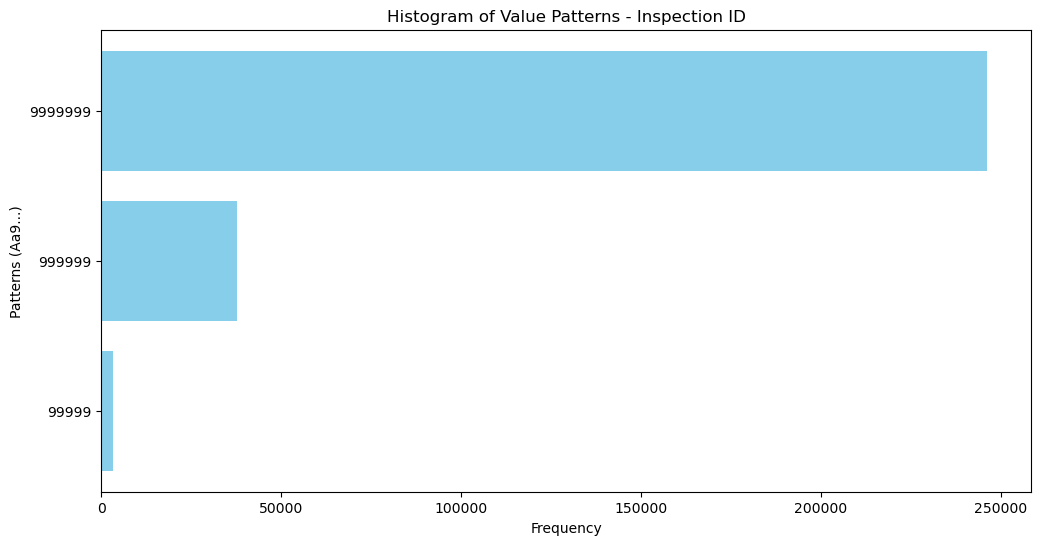

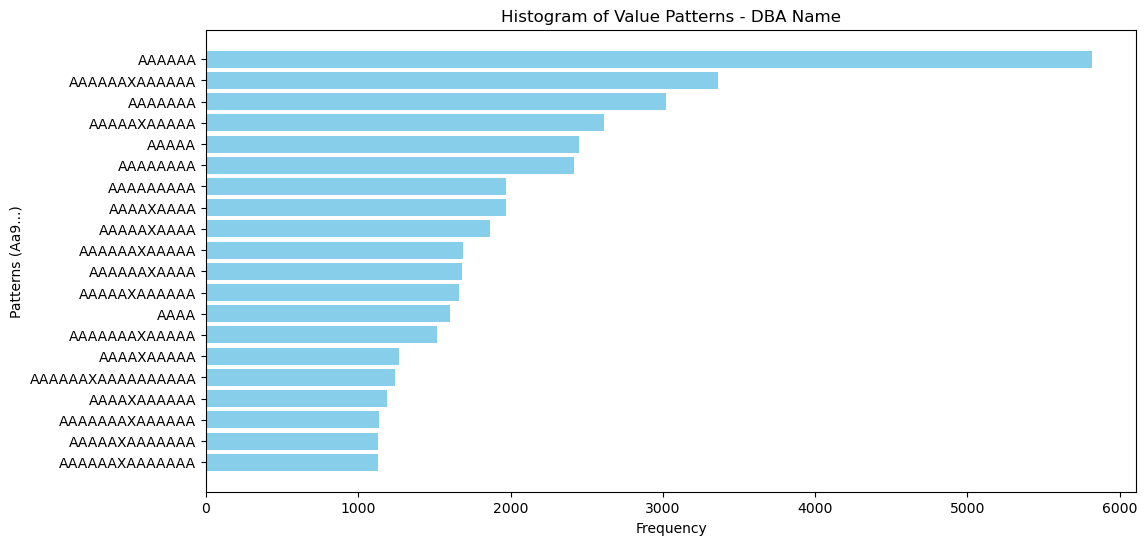

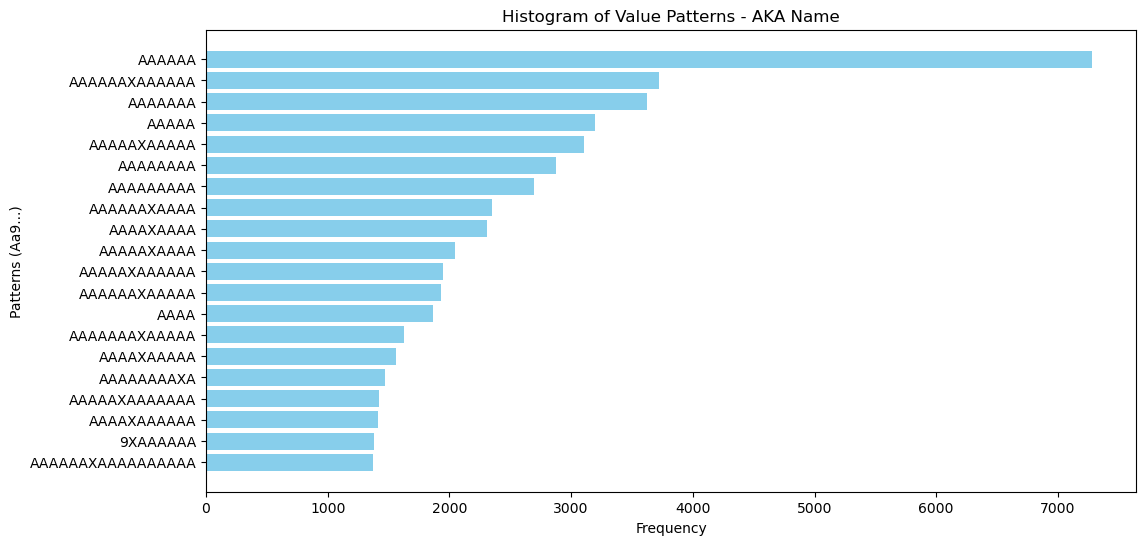

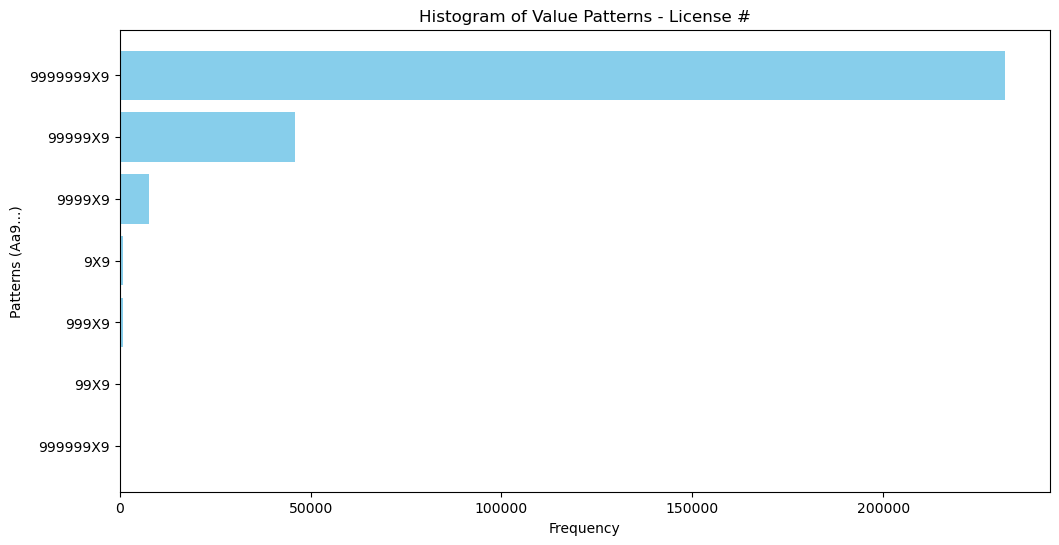

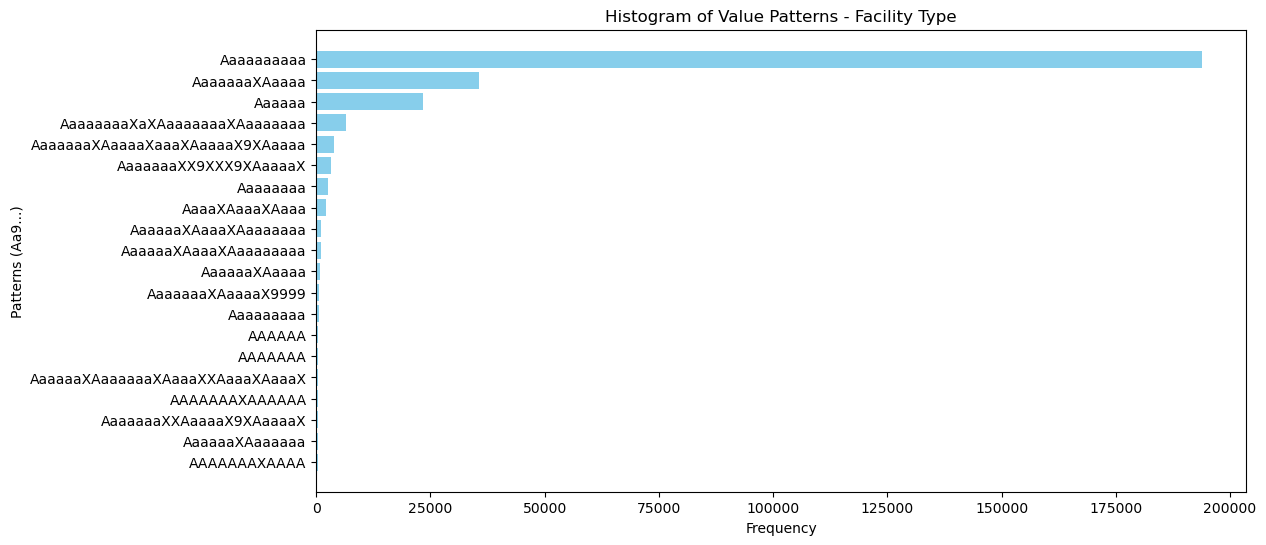

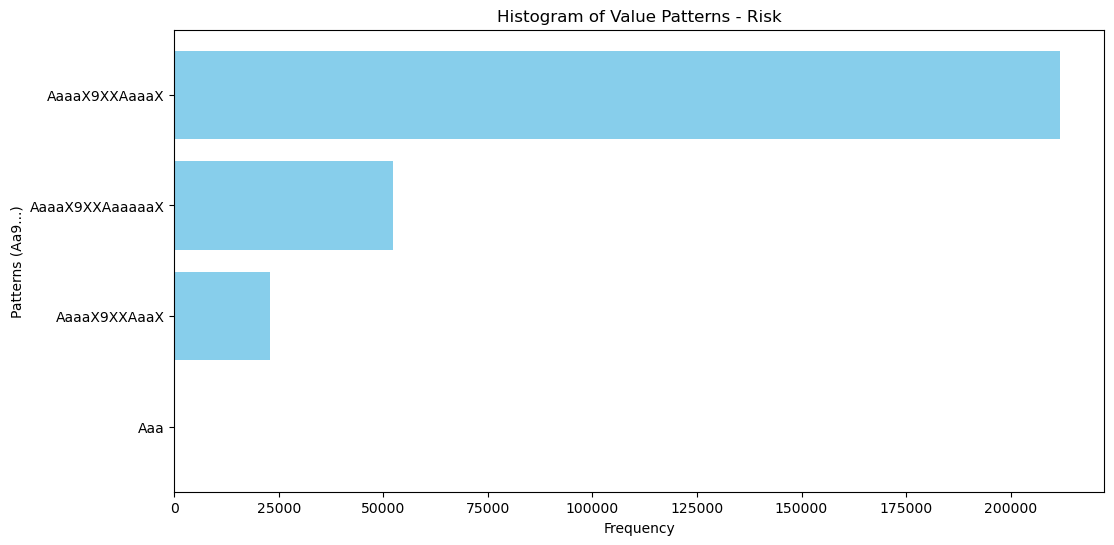

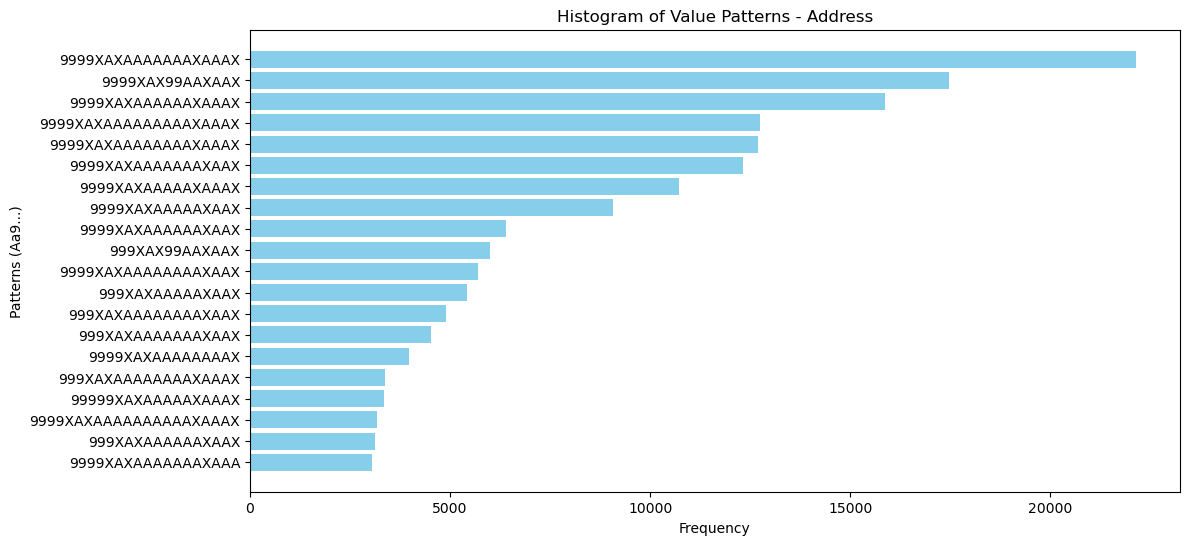

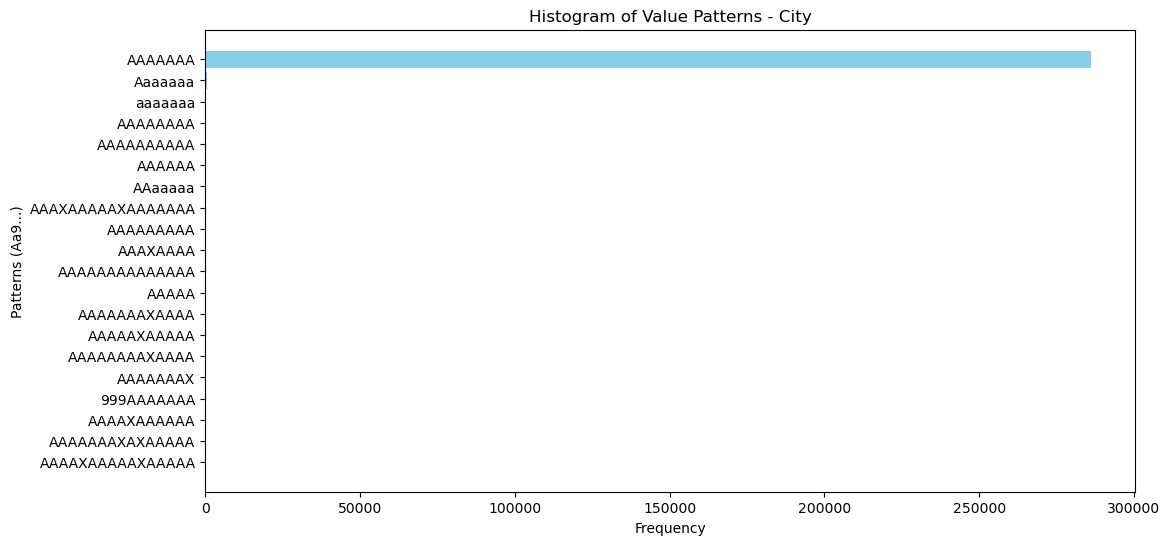

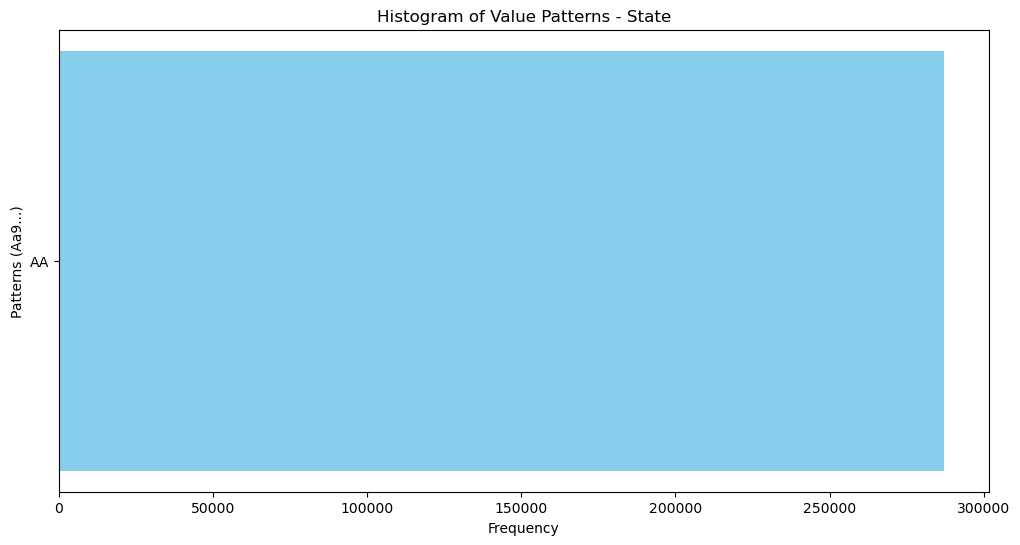

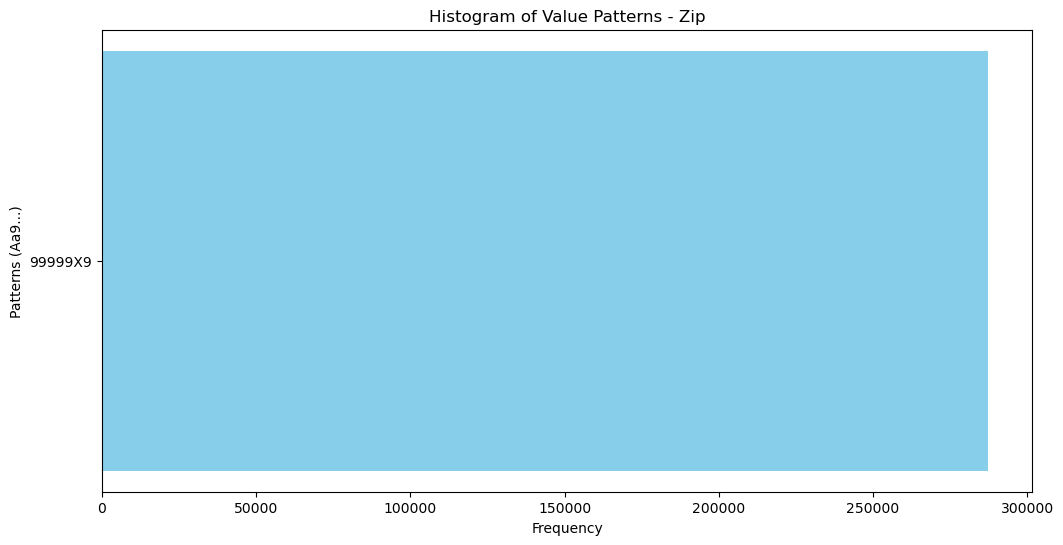

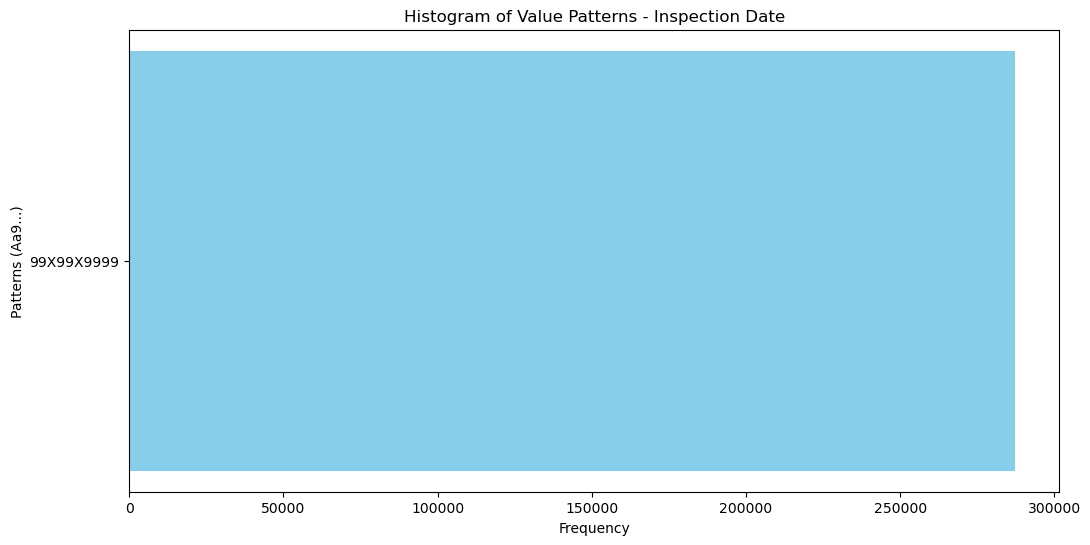

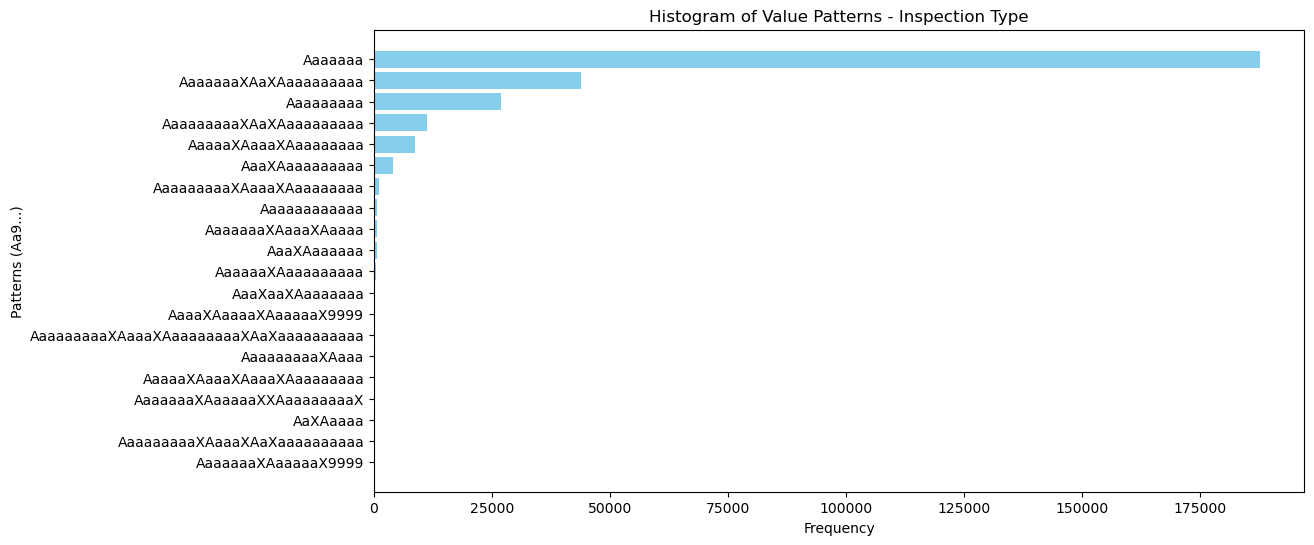

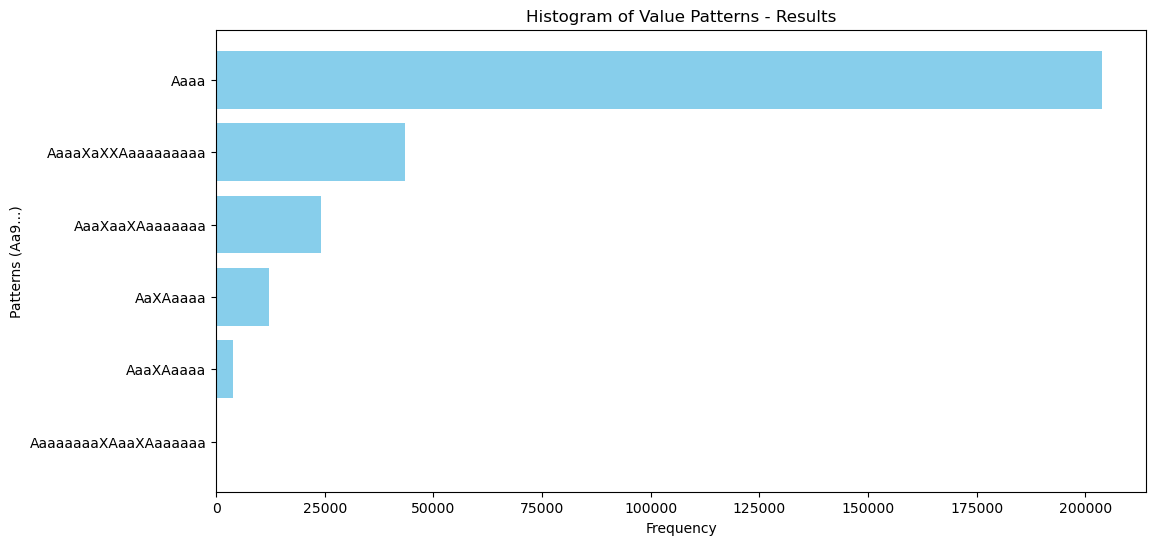

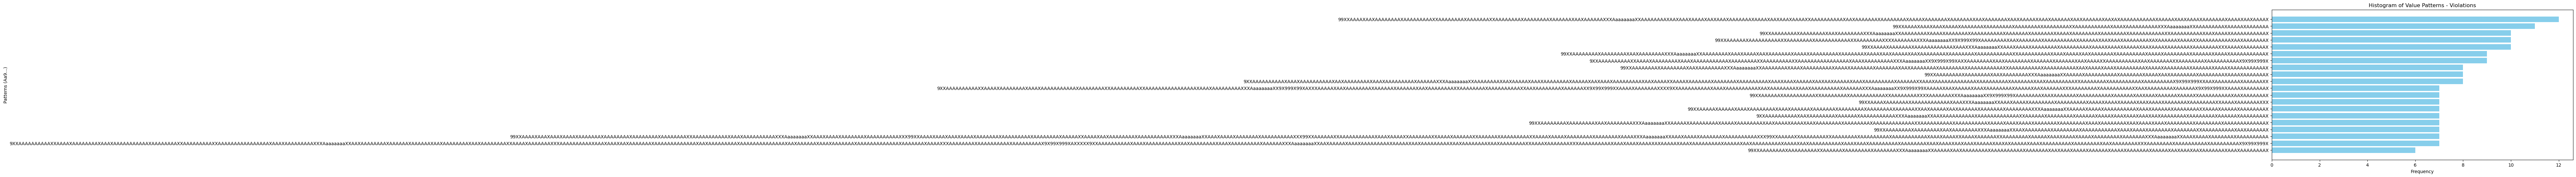

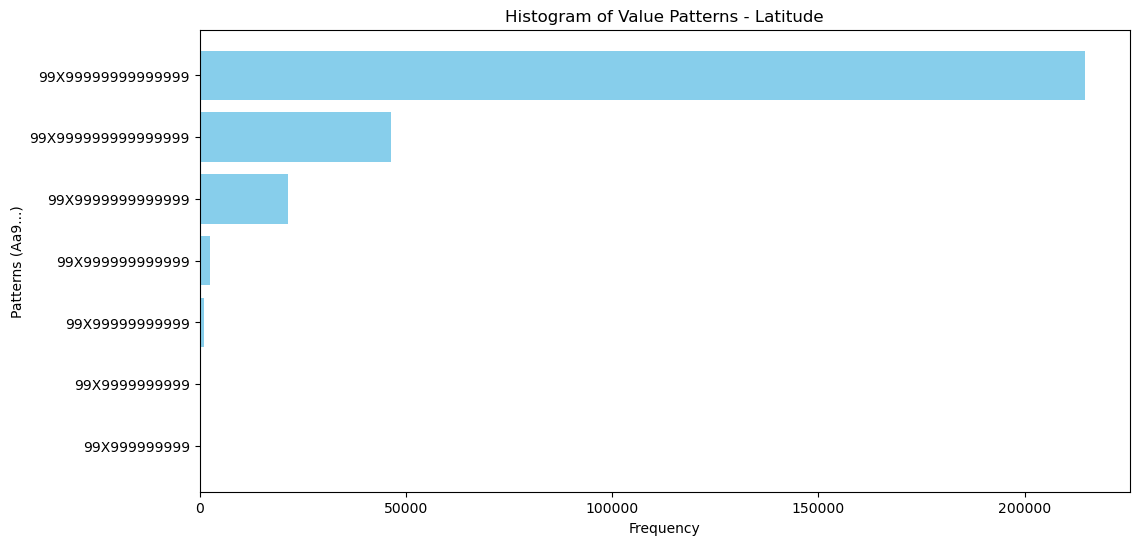

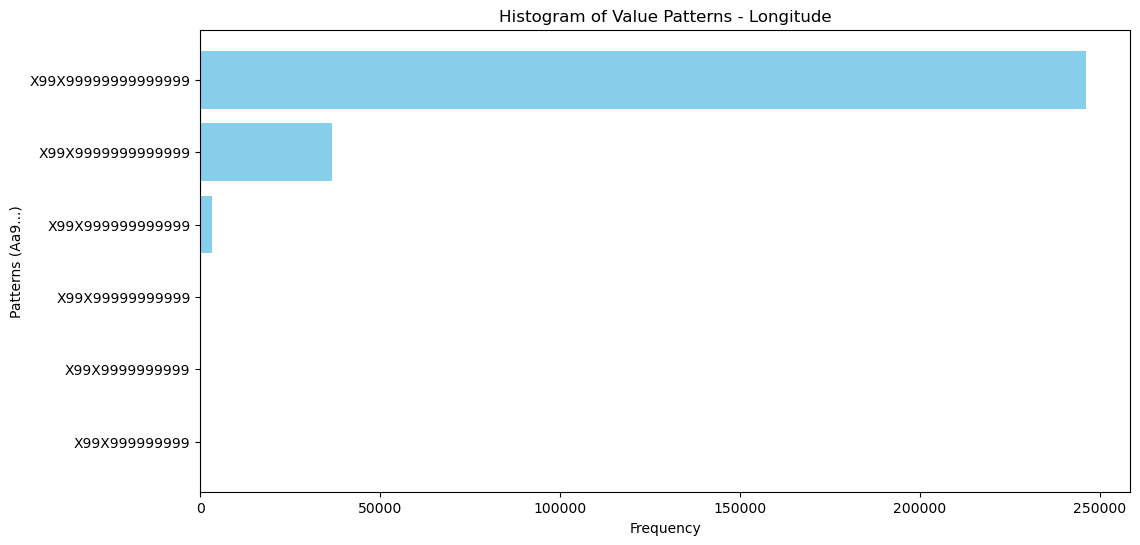

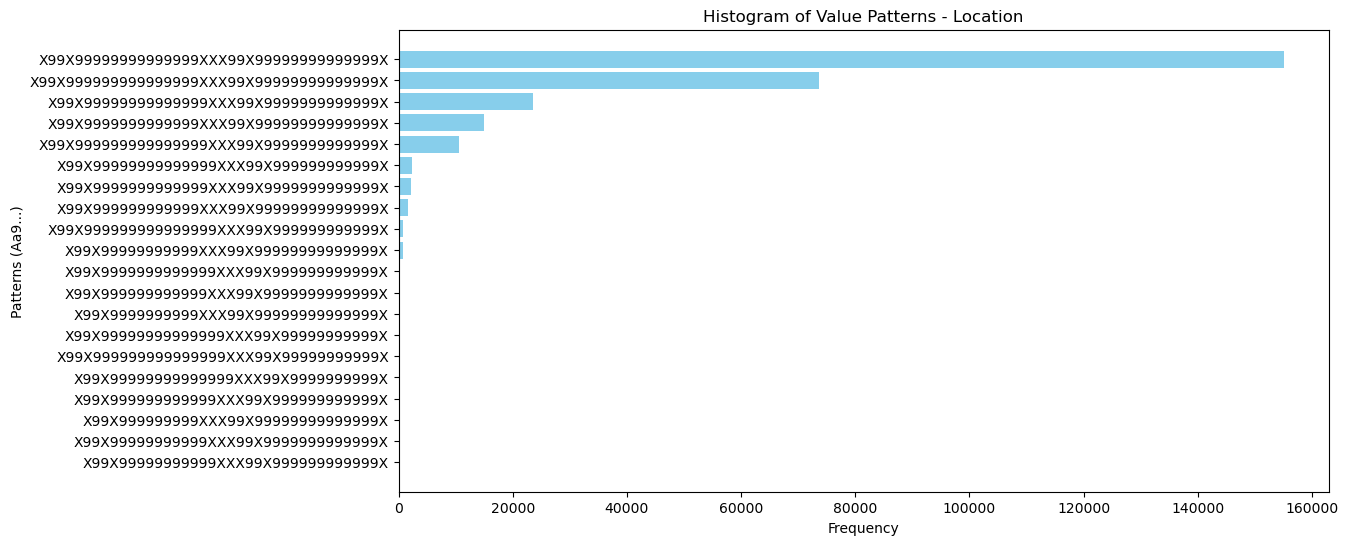

In [24]:
# Function to determine value patterns
def detect_pattern(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    pattern = "".join(["9" if c.isdigit() else "A" if c.isupper() else "a" if c.islower() else "X" for c in value])
    return pattern

# Profiling results for patterns
patterns_results = []
pattern_counts = {}

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue

    # Identify patterns
    patterns = col_data.map(detect_pattern).value_counts().to_dict()

    for pattern, count in patterns.items():
        if pattern in pattern_counts:
            pattern_counts[pattern] += count
        else:
            pattern_counts[pattern] = count

    patterns_results.append({
        "Column": column,
        "Patterns": patterns
    })

# Create a directory to save histograms
output_dir = "column_pattern_histograms"
os.makedirs(output_dir, exist_ok=True)

# Generate histogram for each column
histogram_files = []
for result in patterns_results:
    column = result["Column"]
    patterns = result["Patterns"]

    if not patterns:
        continue

    # Convert dictionary to sorted list
    sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
    pattern_labels, pattern_counts = zip(*sorted_patterns[:20])  # Show top 20 patterns

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.barh(pattern_labels, pattern_counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Patterns (Aa9...)")
    plt.title(f"Histogram of Value Patterns - {column}")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest count on top

print(f"Histograms saved in {output_dir}")

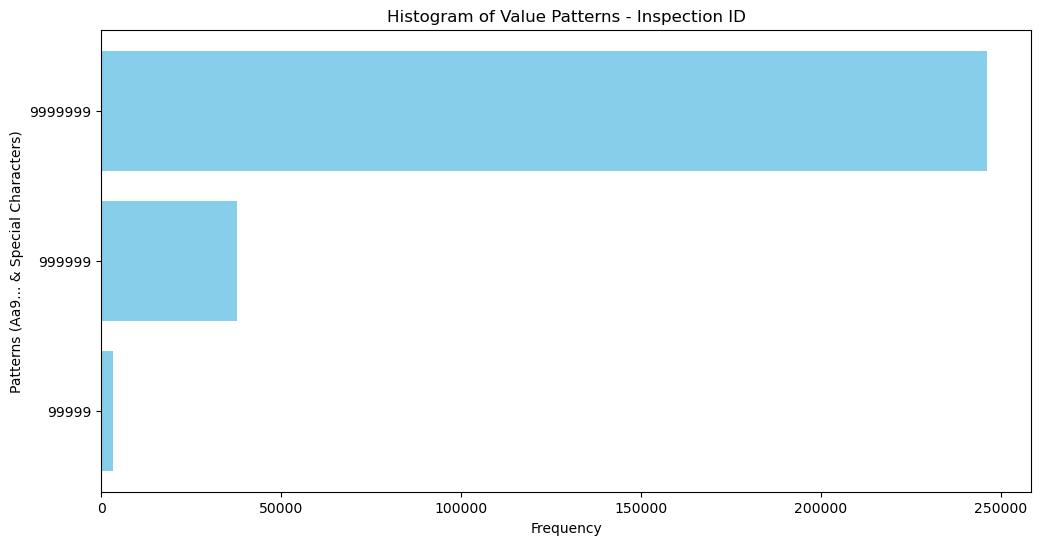

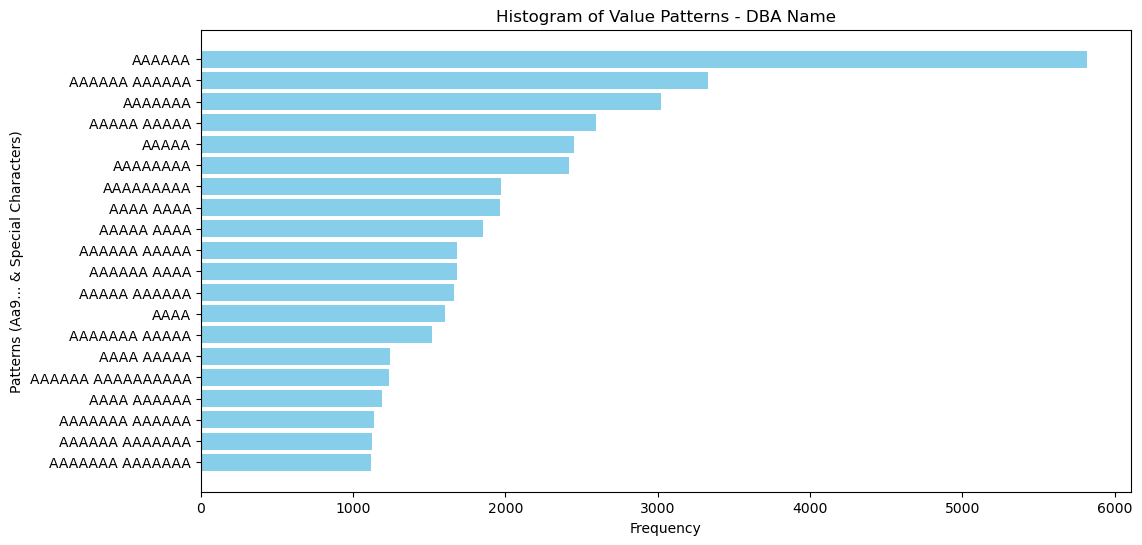

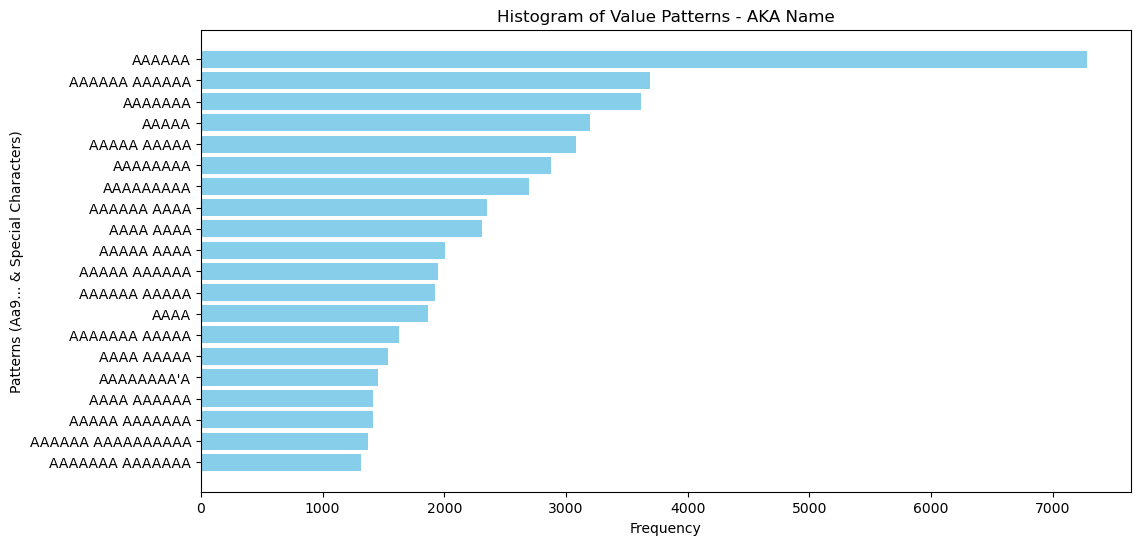

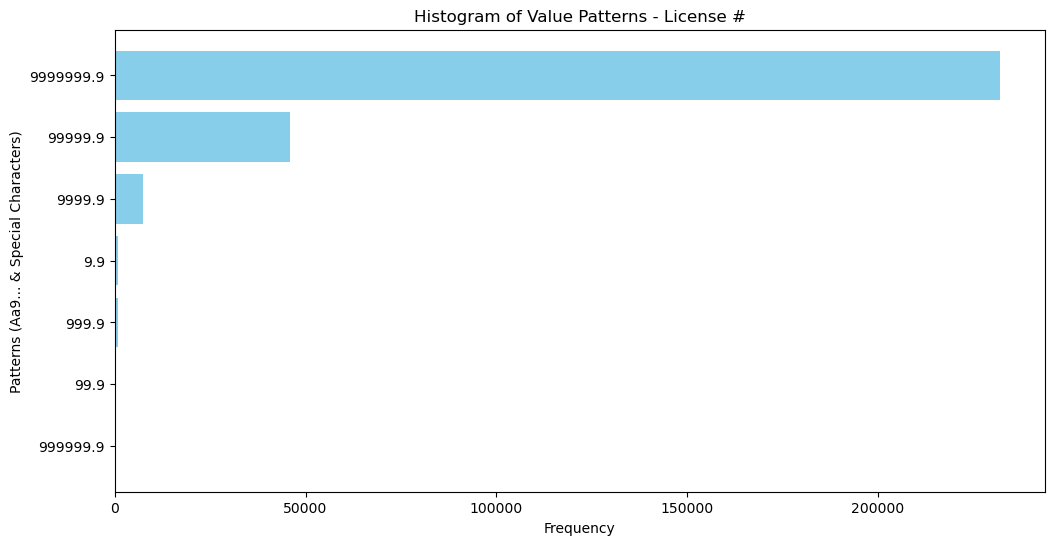

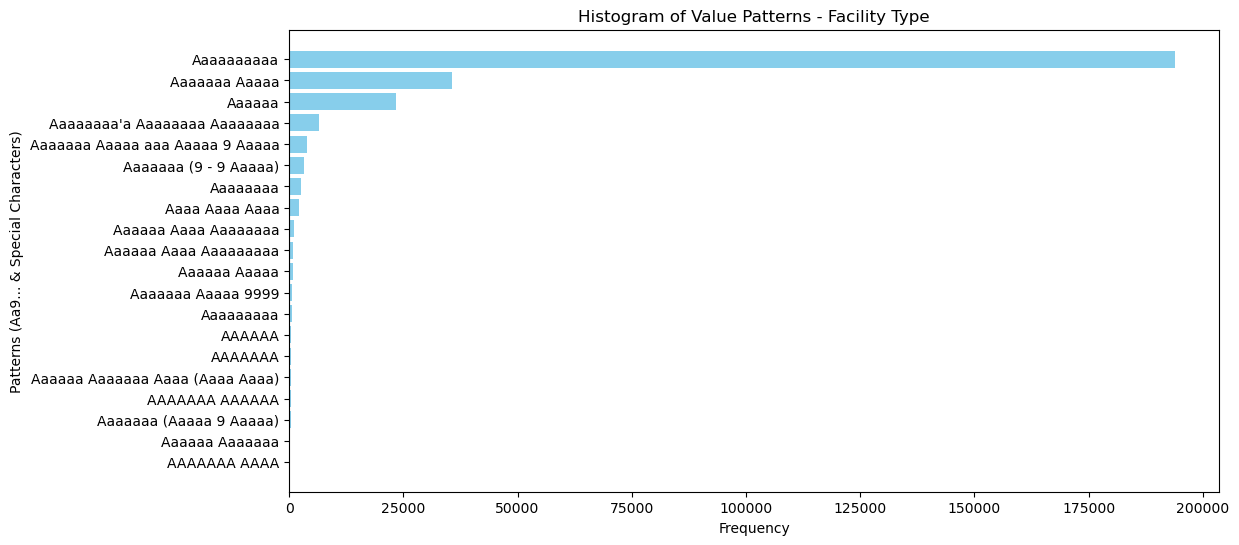

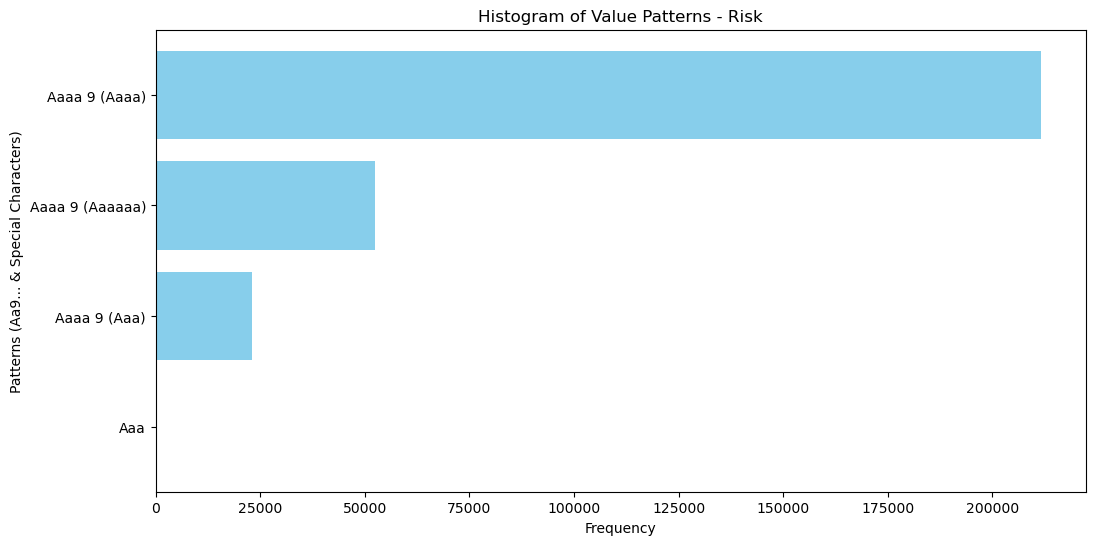

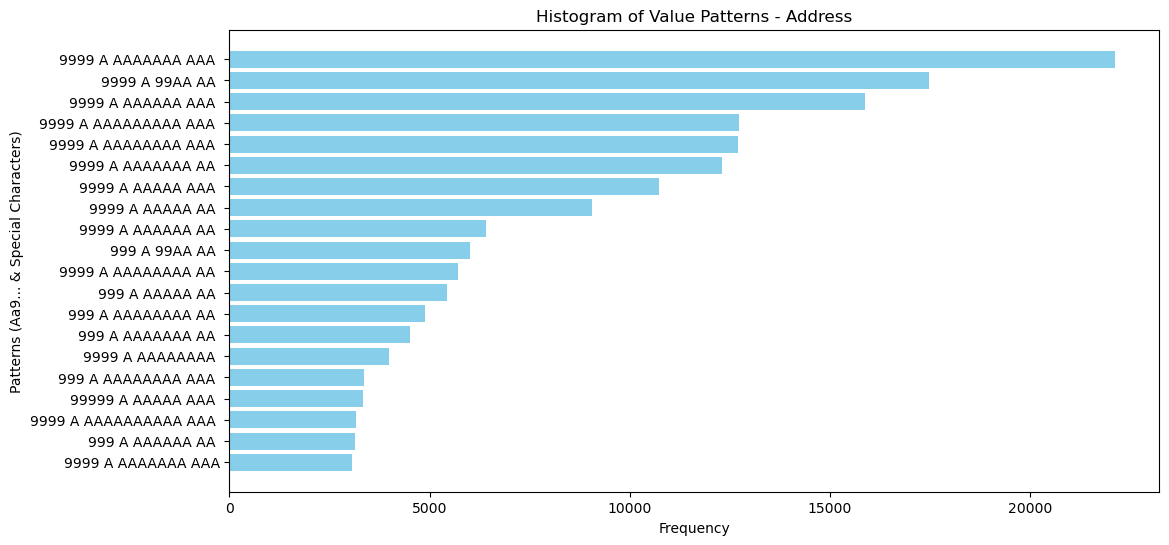

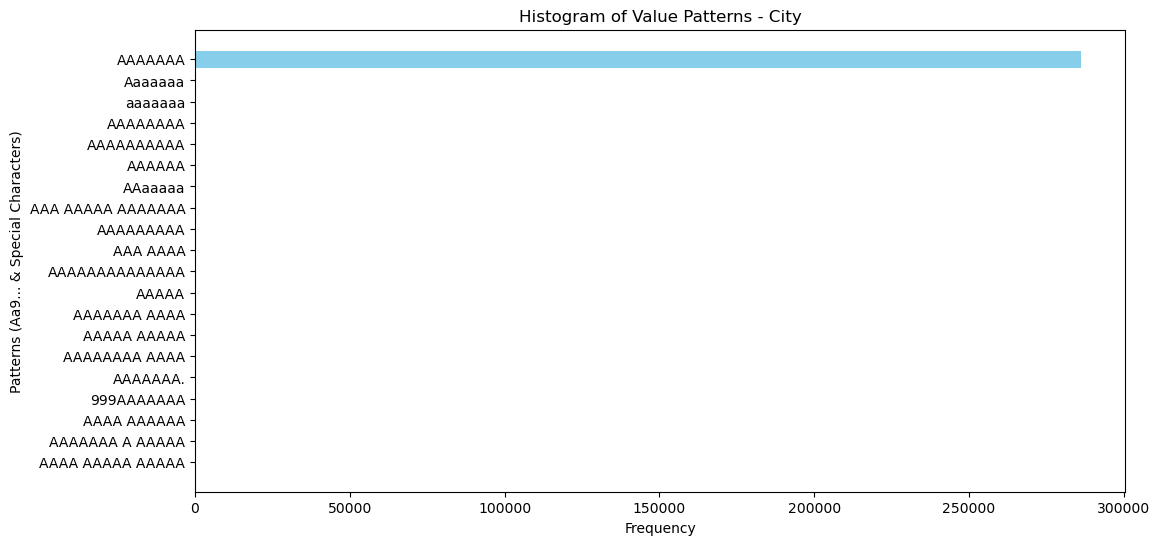

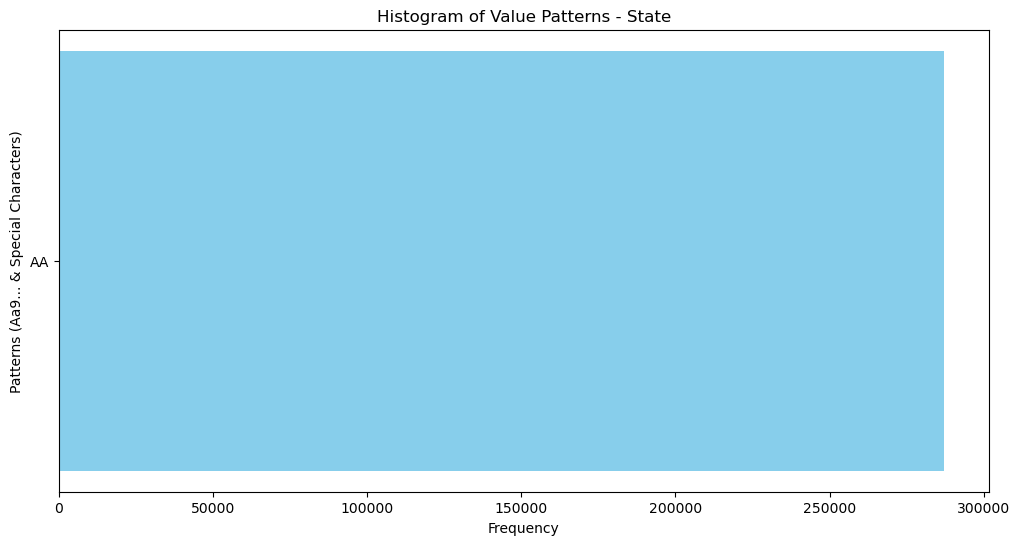

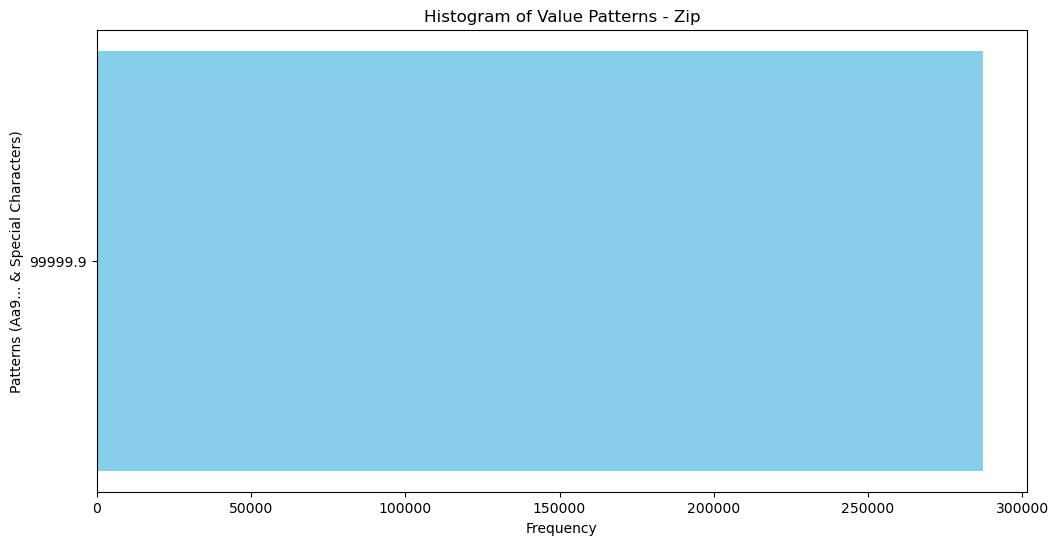

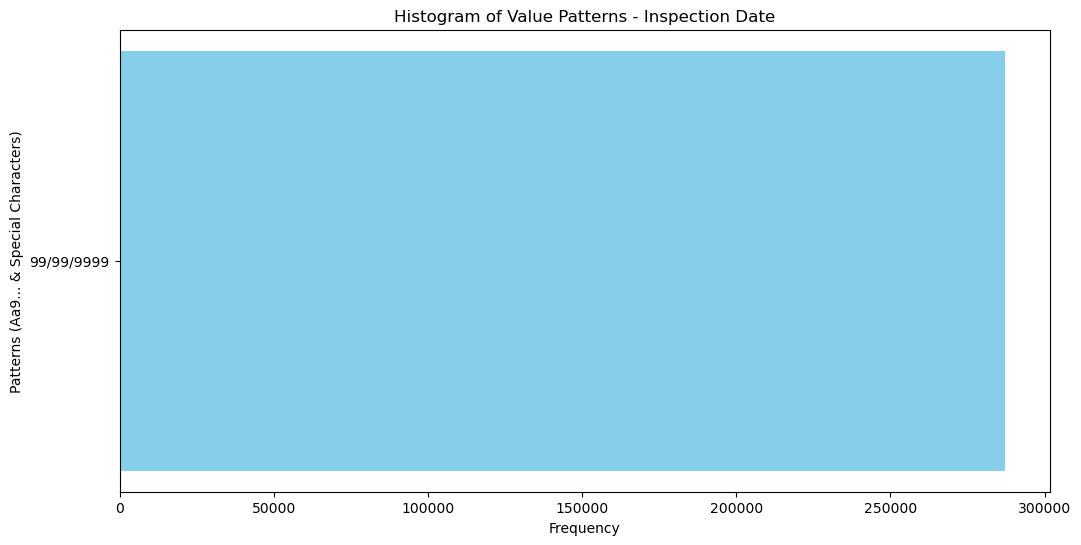

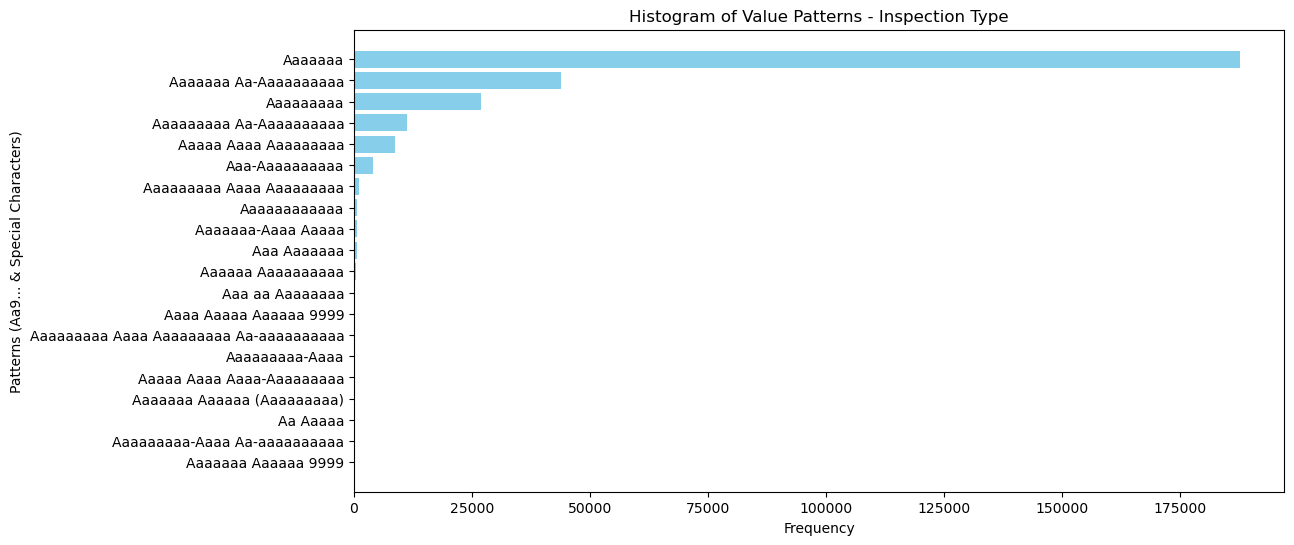

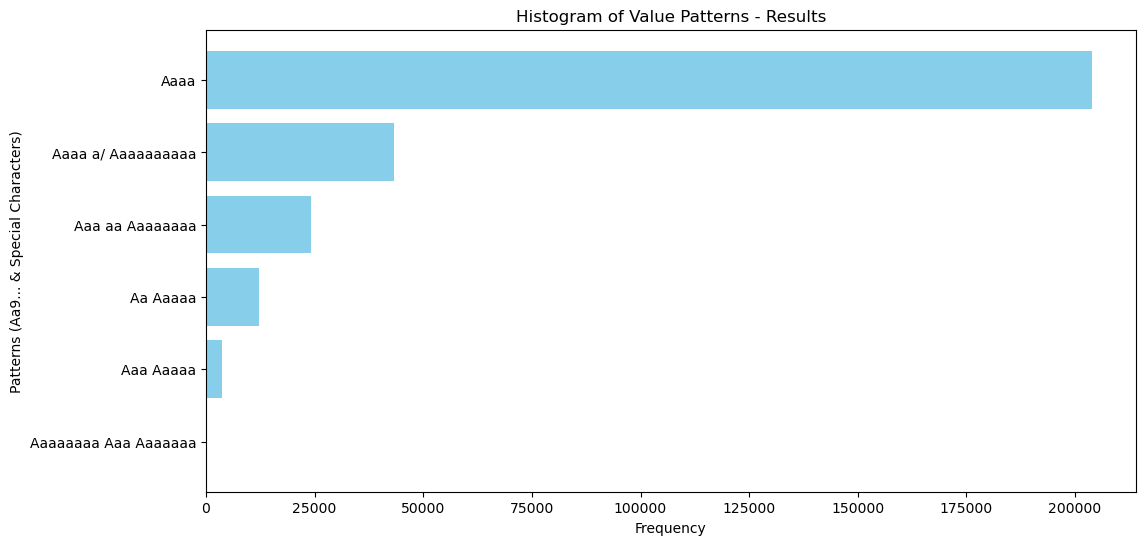

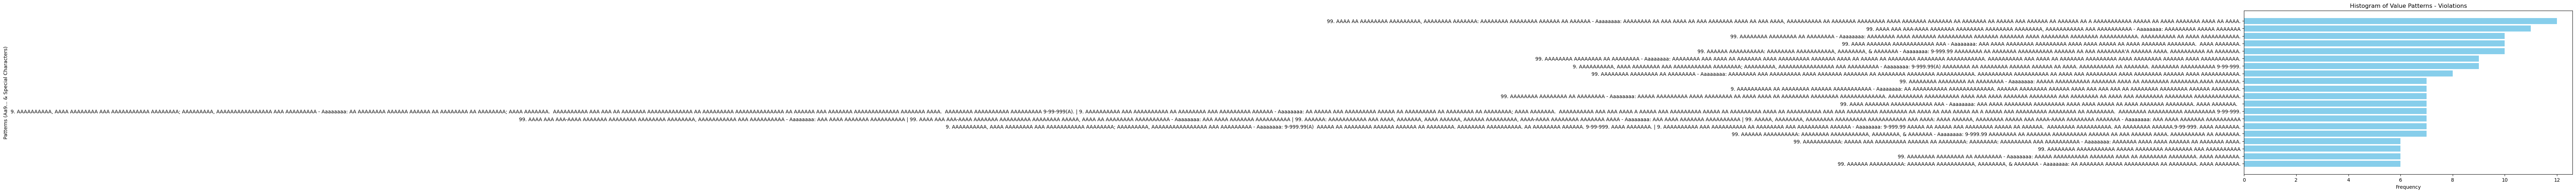

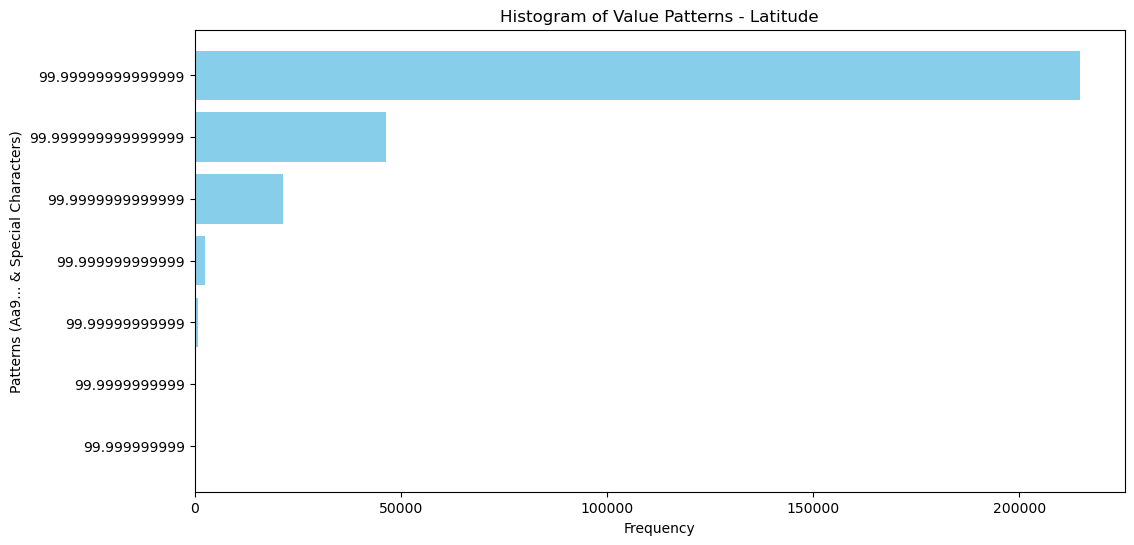

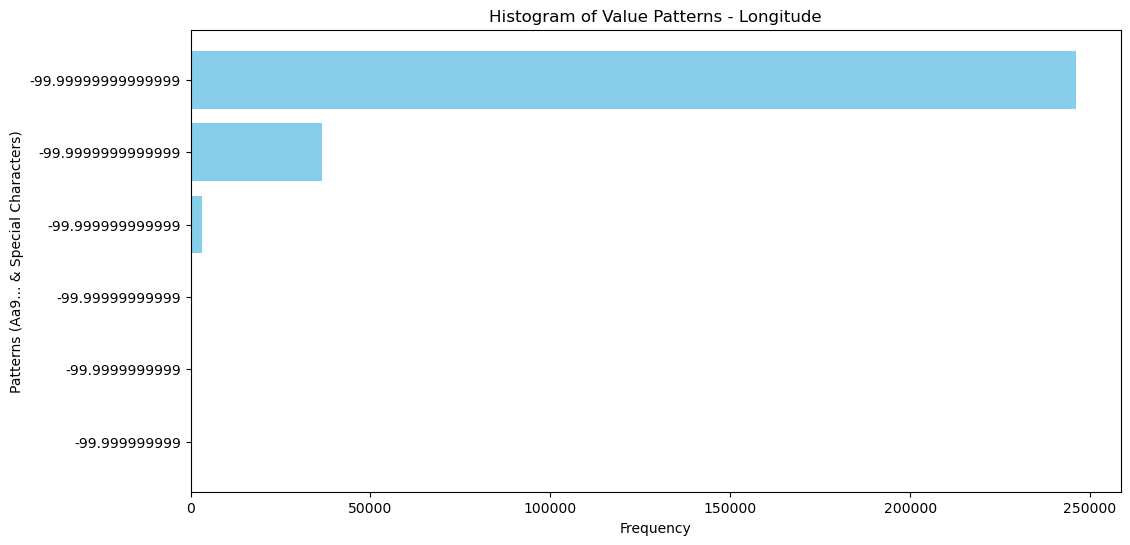

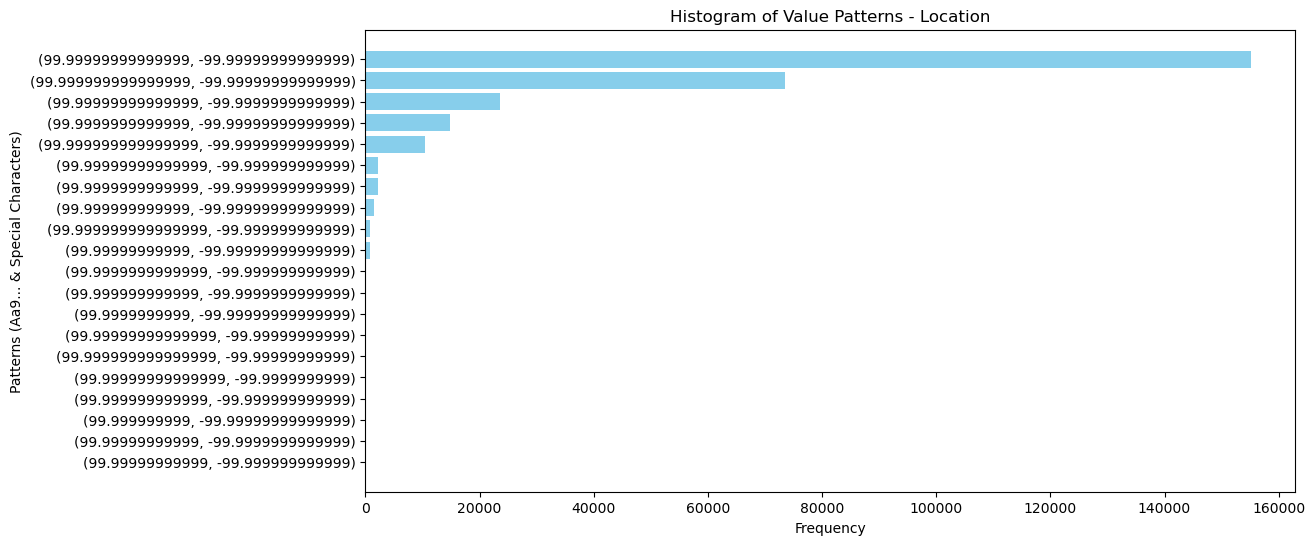

In [28]:
# Function to determine value patterns while keeping special characters
def detect_pattern(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    pattern = "".join(["9" if c.isdigit() else "A" if c.isupper() else "a" if c.islower() else c for c in value])
    return pattern

# Profiling results for patterns
patterns_results = []
pattern_counts = {}

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue

    # Identify patterns
    patterns = col_data.map(detect_pattern).value_counts().to_dict()

    for pattern, count in patterns.items():
        if pattern in pattern_counts:
            pattern_counts[pattern] += count
        else:
            pattern_counts[pattern] = count

    patterns_results.append({
        "Column": column,
        "Patterns": patterns
    })

# Create a directory to save histograms
output_dir = "column_pattern_histograms"
os.makedirs(output_dir, exist_ok=True)

# Generate histogram for each column
histogram_files = []
for result in patterns_results:
    column = result["Column"]
    patterns = result["Patterns"]

    if not patterns:
        continue

    # Convert dictionary to sorted list
    sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
    pattern_labels, pattern_counts = zip(*sorted_patterns[:20])  # Show top 20 patterns

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.barh(pattern_labels, pattern_counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Patterns (Aa9... & Special Characters)")
    plt.title(f"Histogram of Value Patterns - {column}")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest count on top





In [30]:
#patterns_results

Pattern summary saved in column_pattern_summary.csv


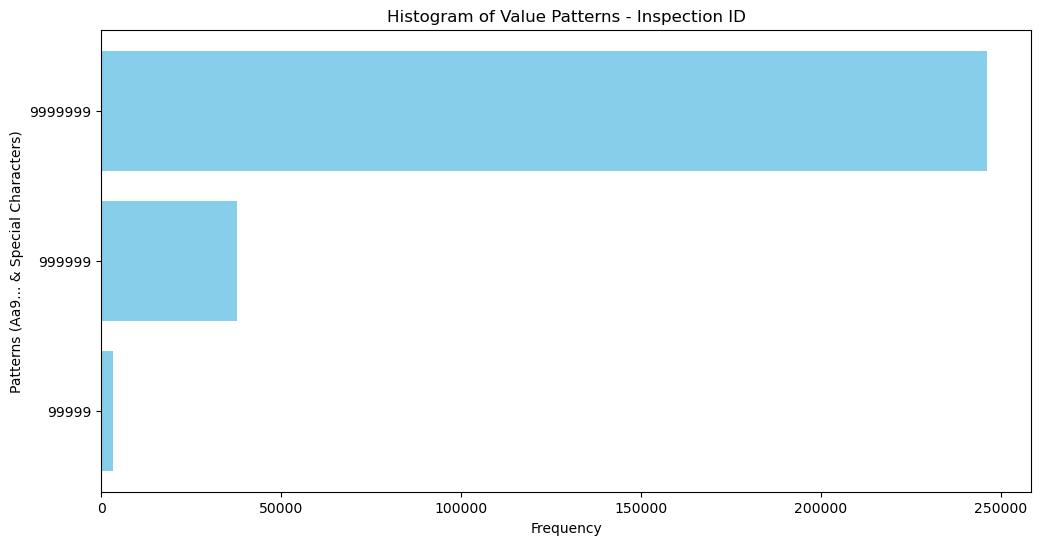

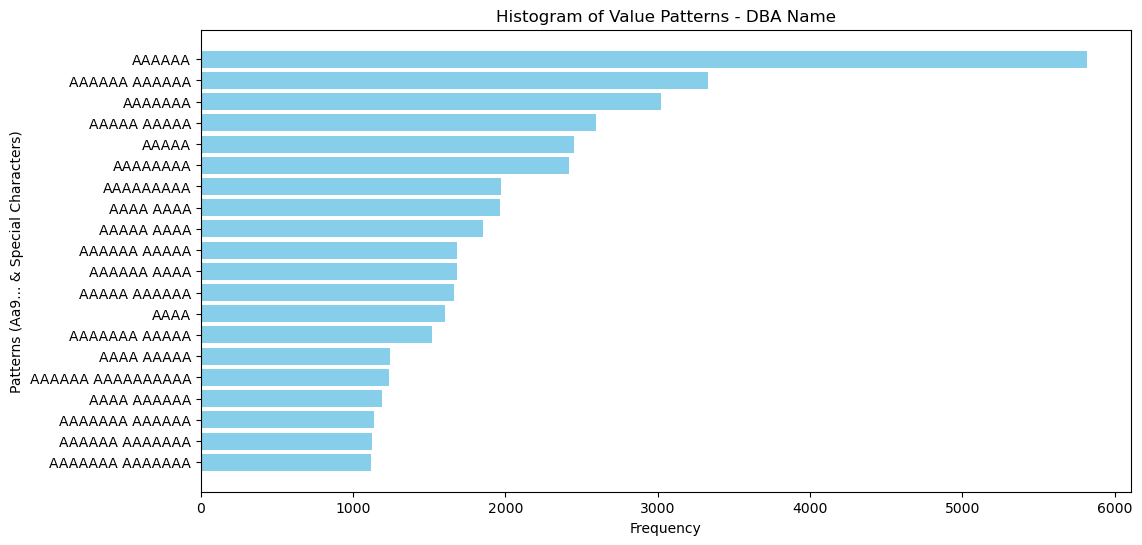

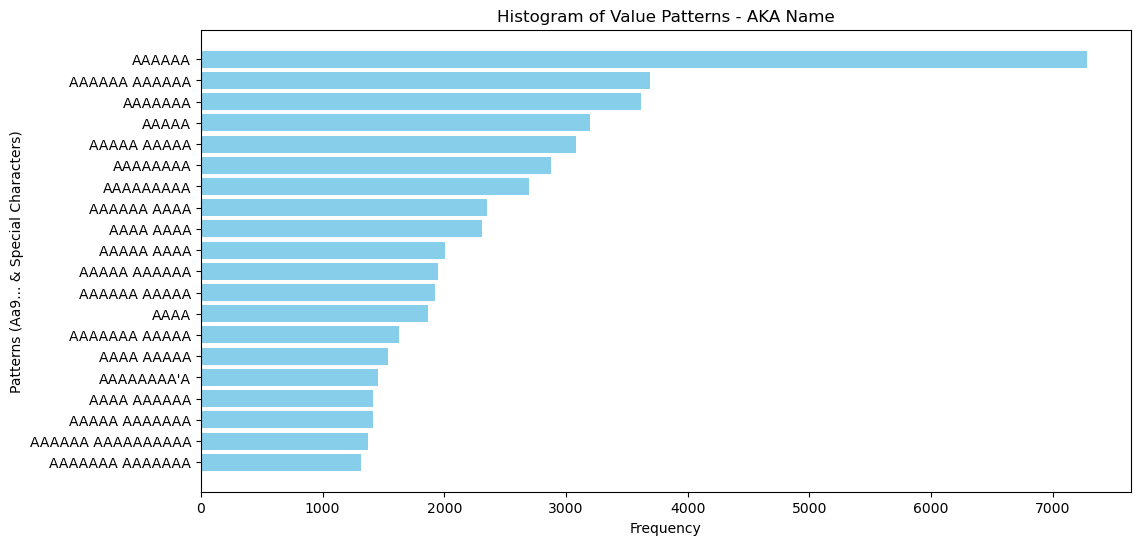

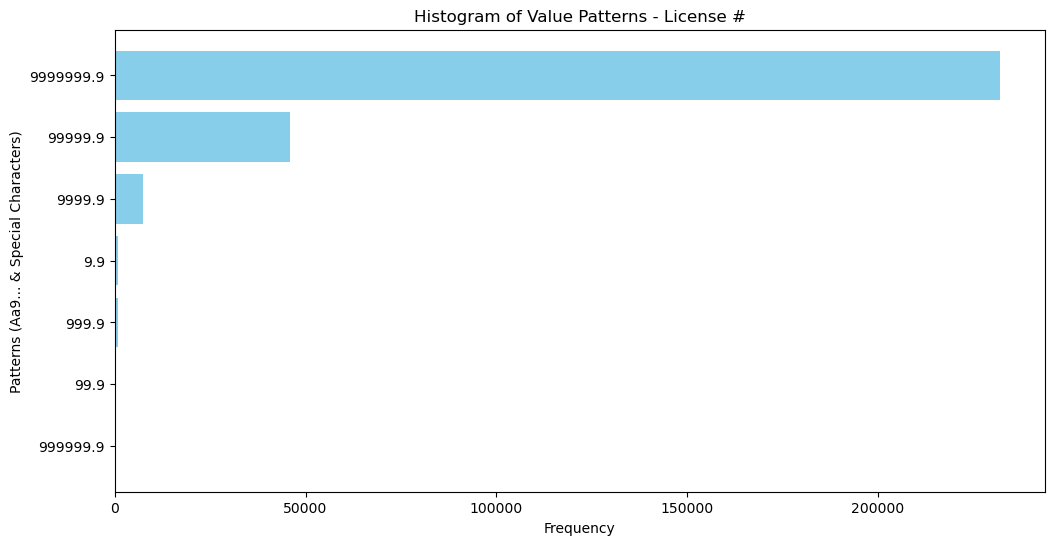

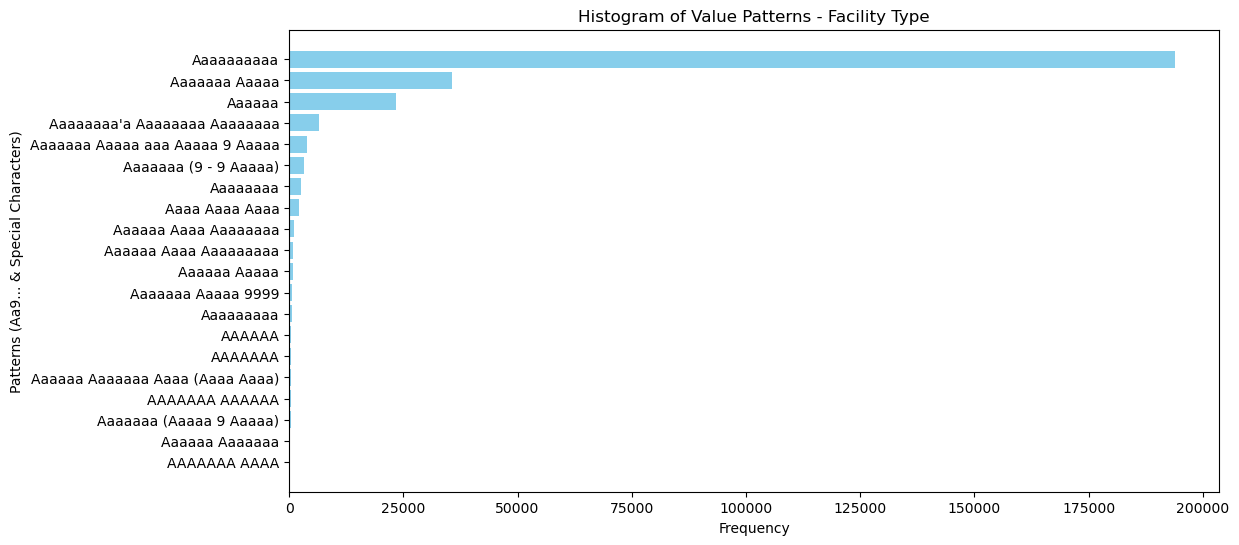

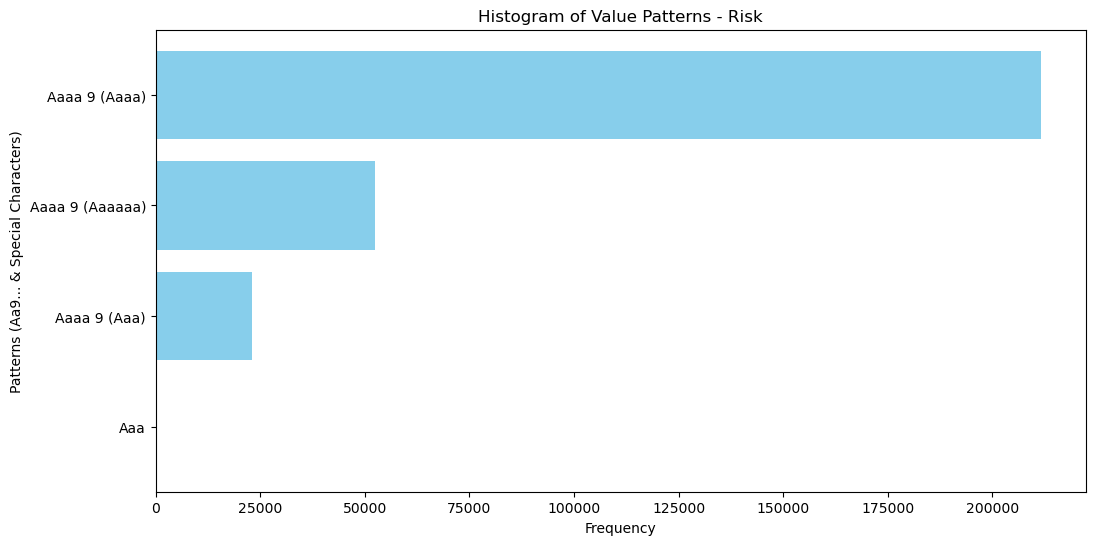

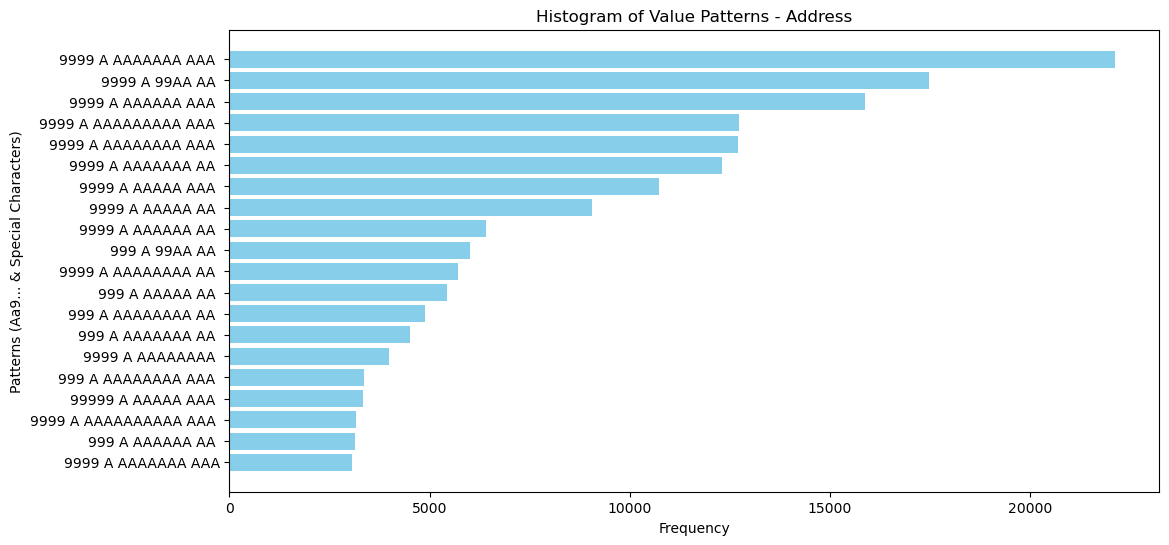

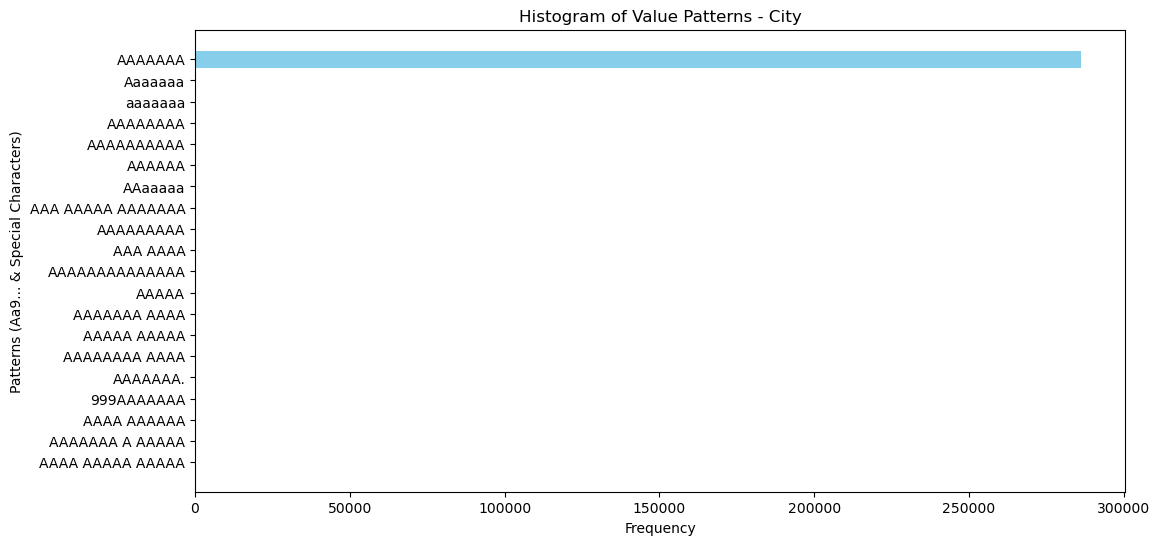

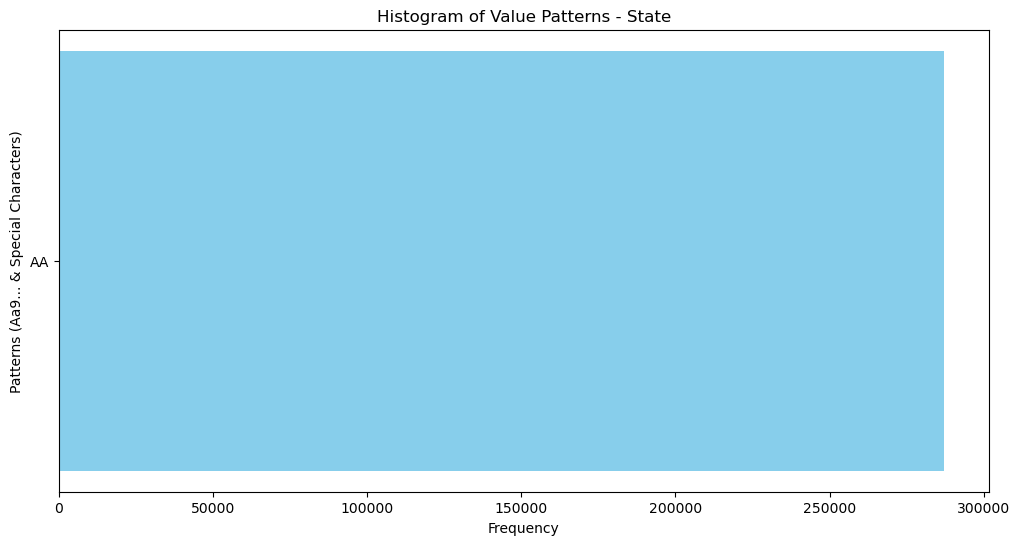

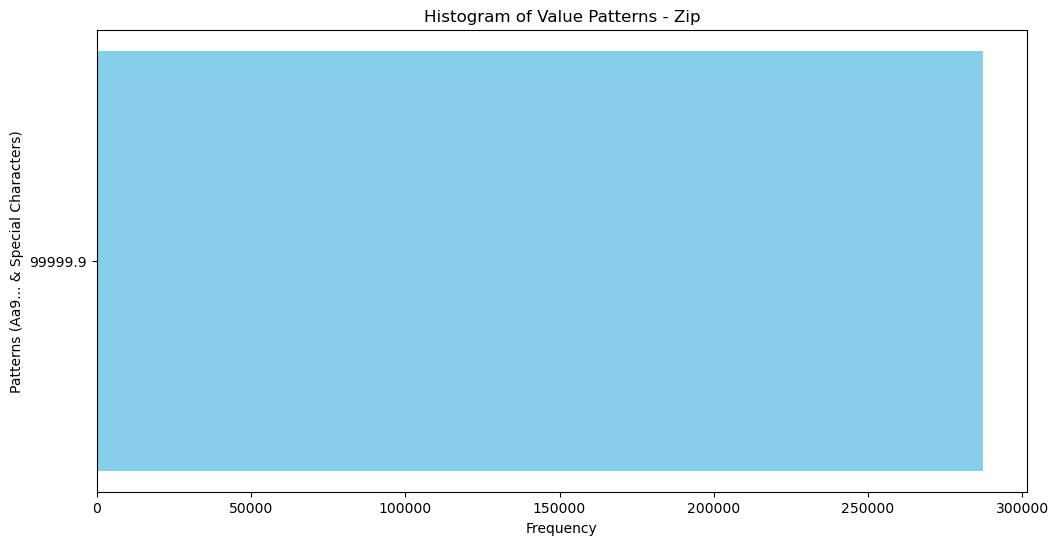

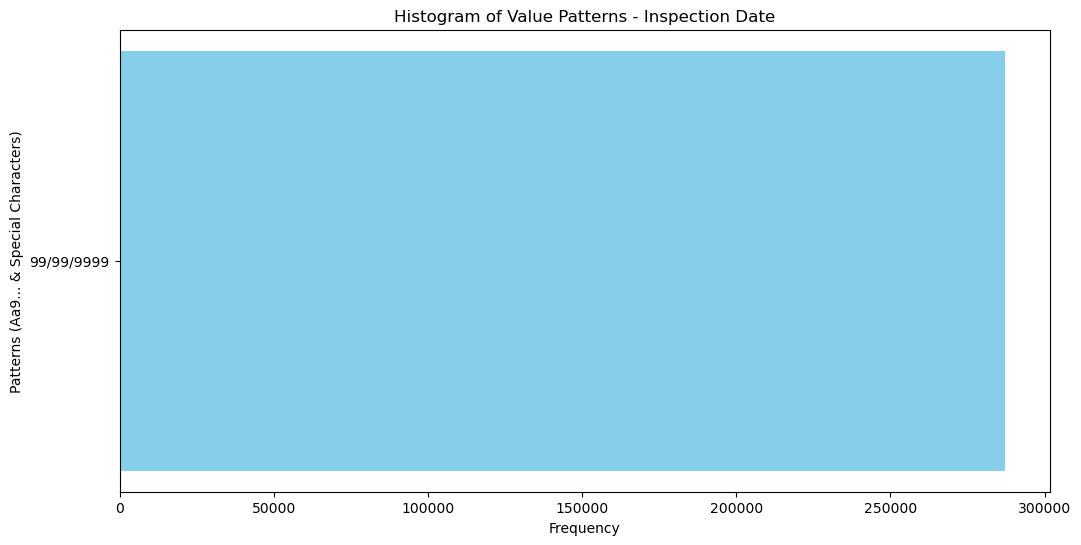

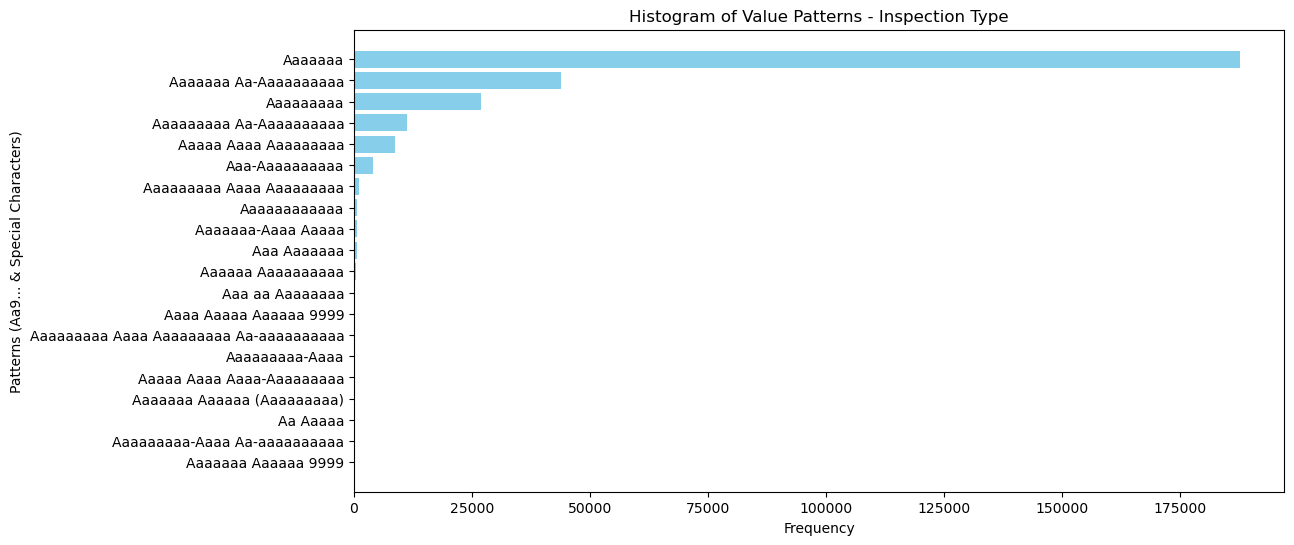

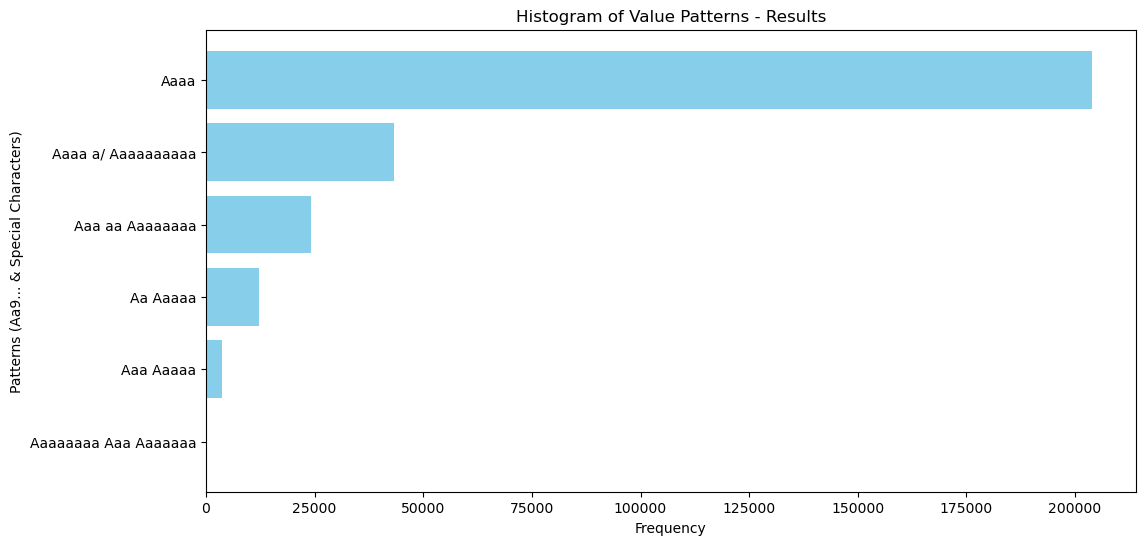

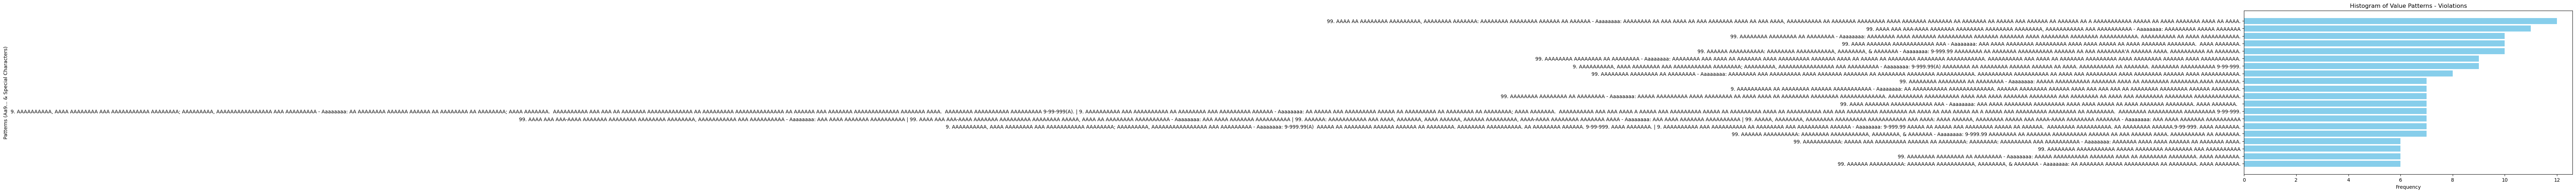

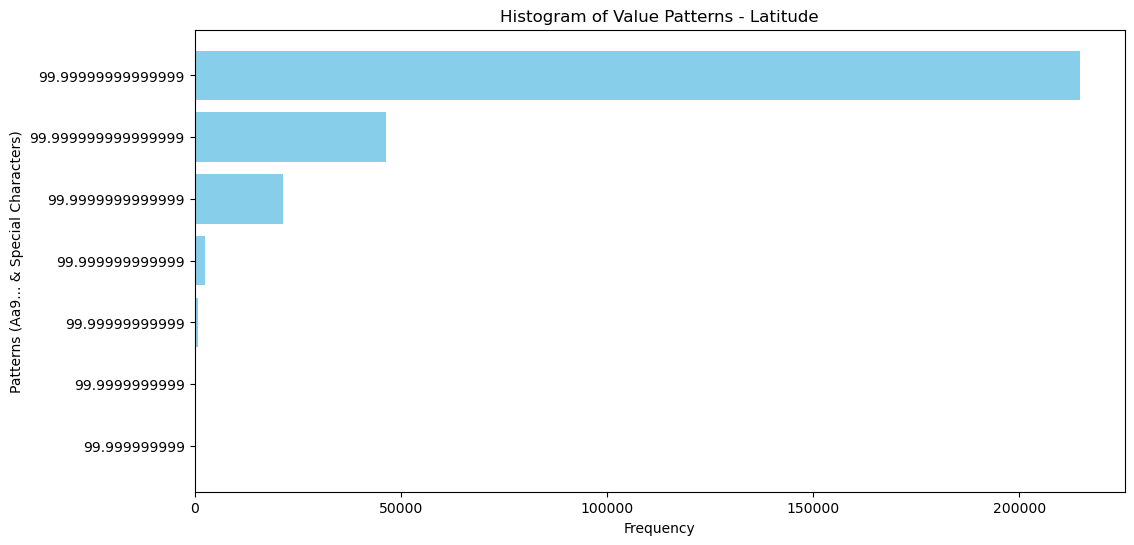

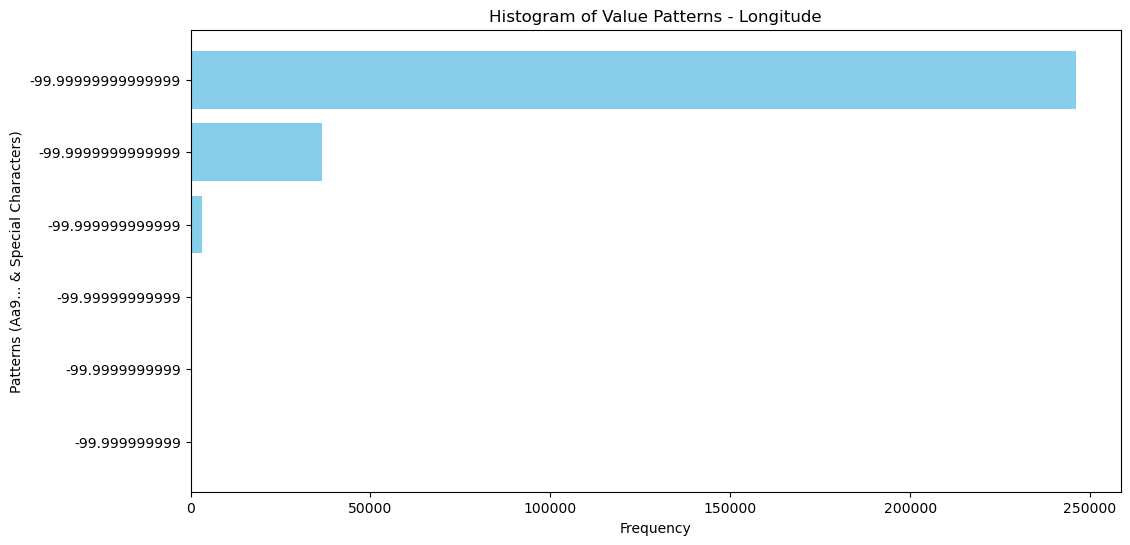

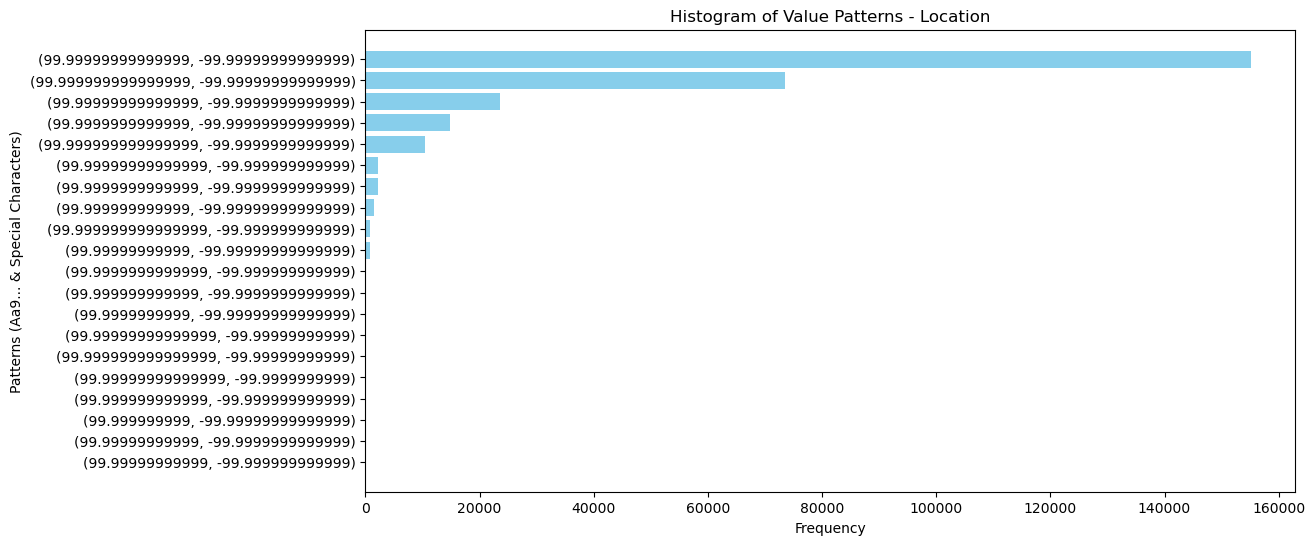

In [35]:

# Function to determine value patterns while keeping special characters
def detect_pattern(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)
    pattern = "".join(["9" if c.isdigit() else "A" if c.isupper() else "a" if c.islower() else c for c in value])
    return pattern

# Profiling results for patterns
patterns_results = []
pattern_counts = {}
column_pattern_summary = []  # To store number of patterns per column

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue

    # Identify patterns
    patterns = col_data.map(detect_pattern).value_counts().to_dict()

    for pattern, count in patterns.items():
        if pattern in pattern_counts:
            pattern_counts[pattern] += count
        else:
            pattern_counts[pattern] = count

    # Store pattern count summary for the column
    column_pattern_summary.append({"Column": column, "Total Unique Patterns": len(patterns)})

    patterns_results.append({
        "Column": column,
        "Patterns": patterns
    })

# Save the number of patterns in each column to a CSV file
summary_df = pd.DataFrame(column_pattern_summary)
summary_file_path = "column_pattern_summary.csv"
summary_df.to_csv(summary_file_path, index=False)
print(f"Pattern summary saved in {summary_file_path}")

# Create a directory to save histograms
output_dir = "column_pattern_histograms"
os.makedirs(output_dir, exist_ok=True)

# Generate histogram for each column
histogram_files = []
for result in patterns_results:
    column = result["Column"]
    patterns = result["Patterns"]

    if not patterns:
        continue

    # Convert dictionary to sorted list
    sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
    pattern_labels, pattern_counts = zip(*sorted_patterns[:20])  # Show top 20 patterns

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.barh(pattern_labels, pattern_counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Patterns (Aa9... & Special Characters)")
    plt.title(f"Histogram of Value Patterns - {column}")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest count on top




Pattern summary saved in column_pattern_summary.csv


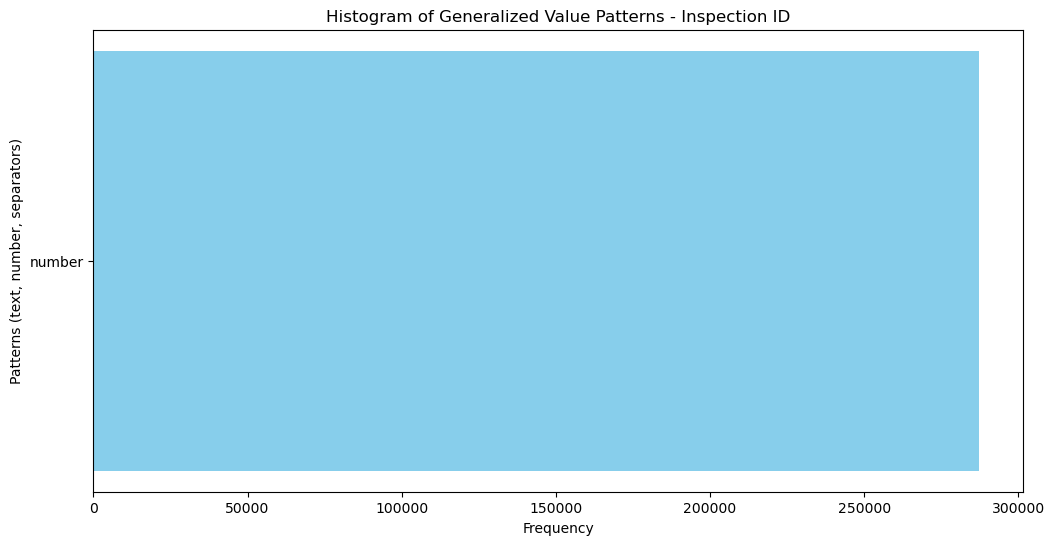

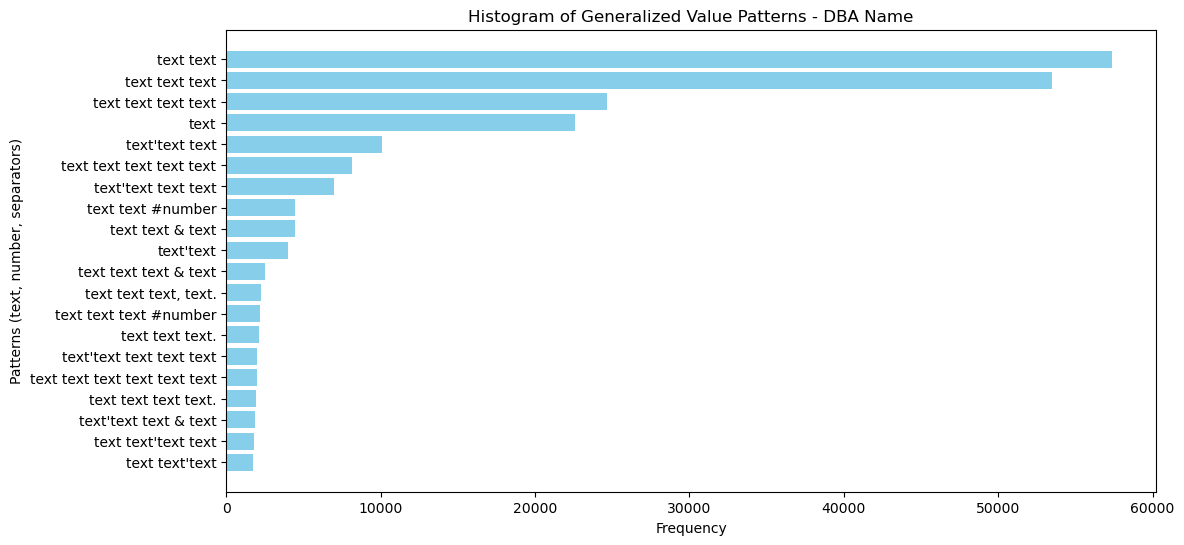

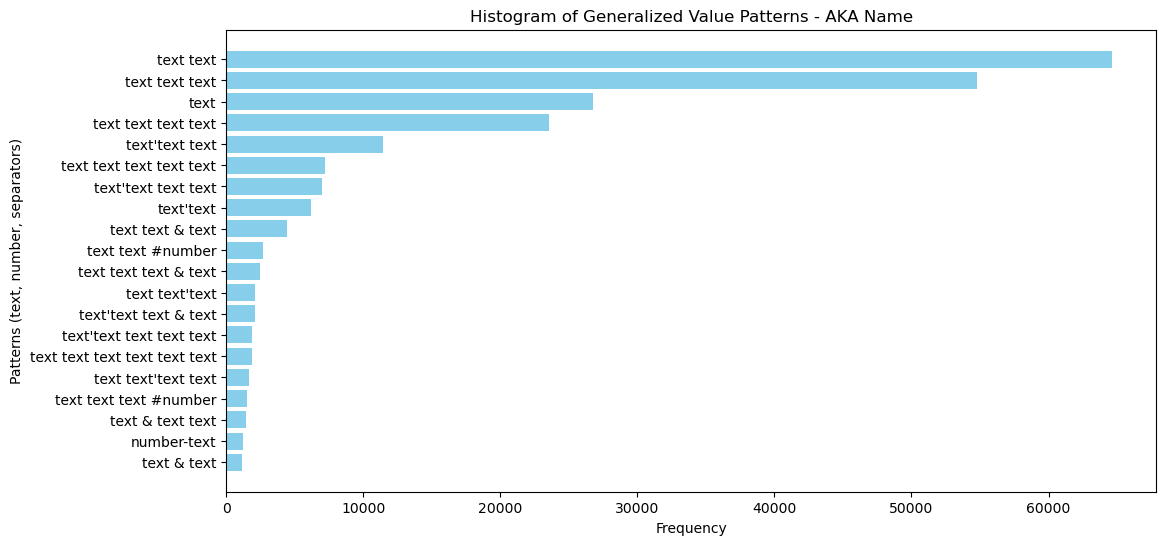

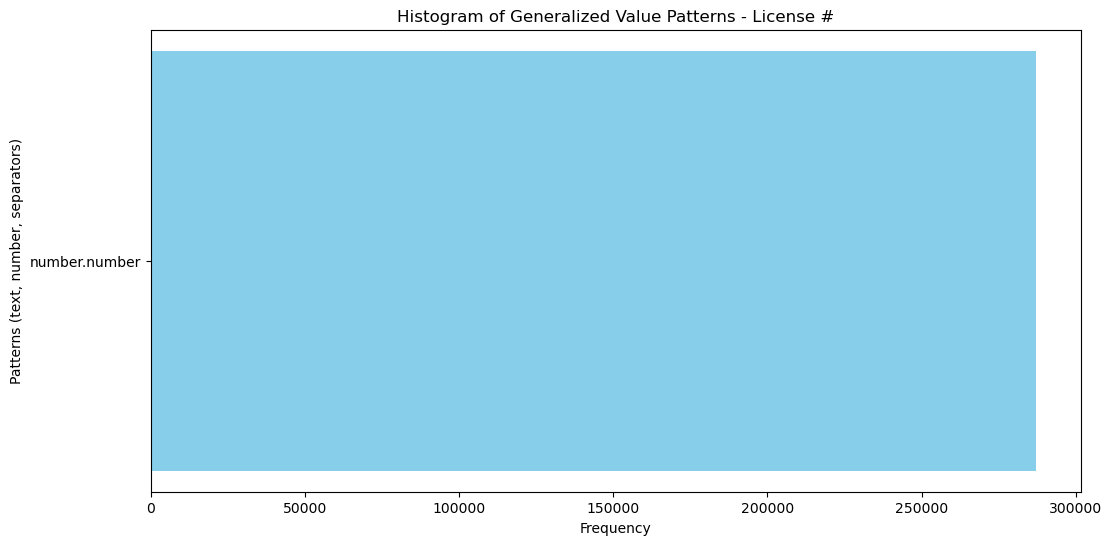

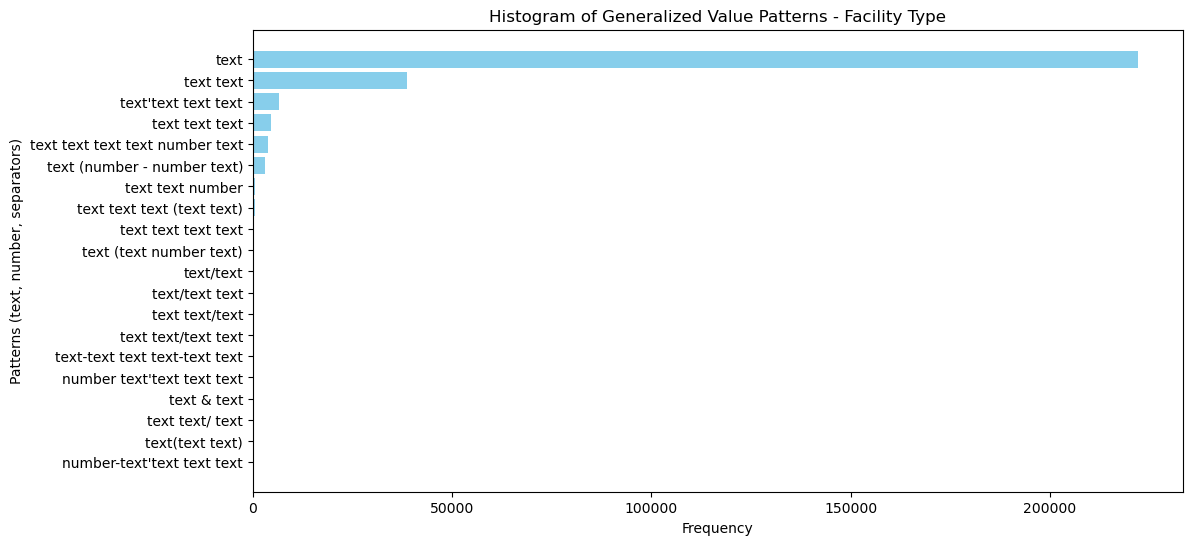

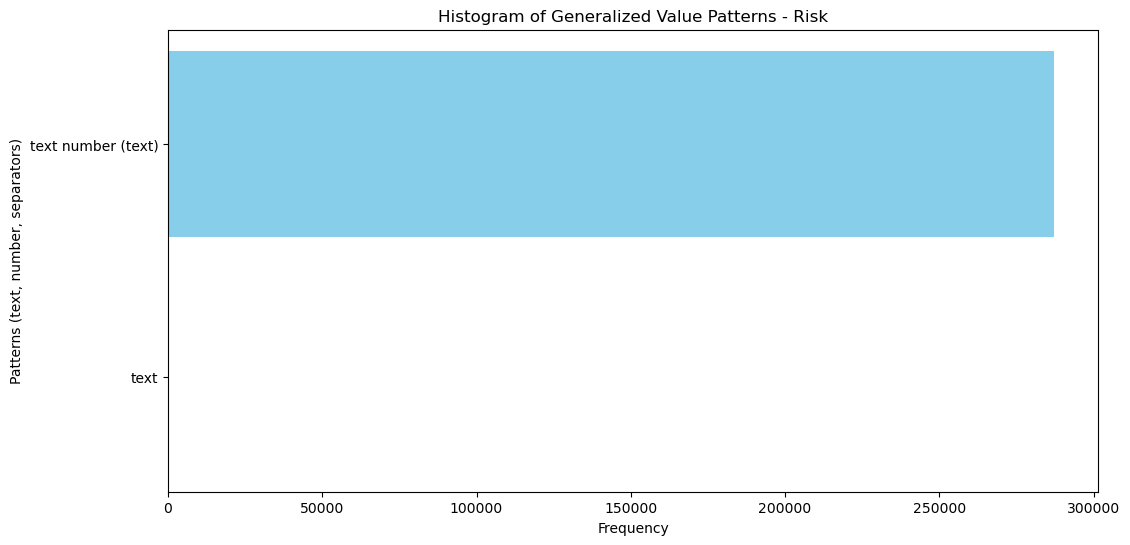

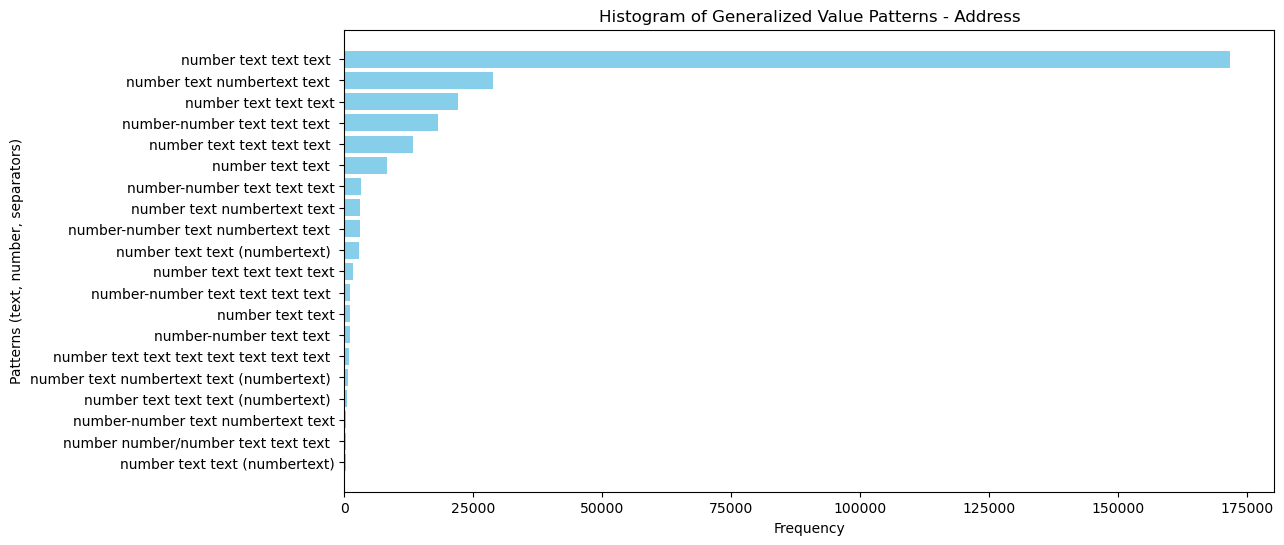

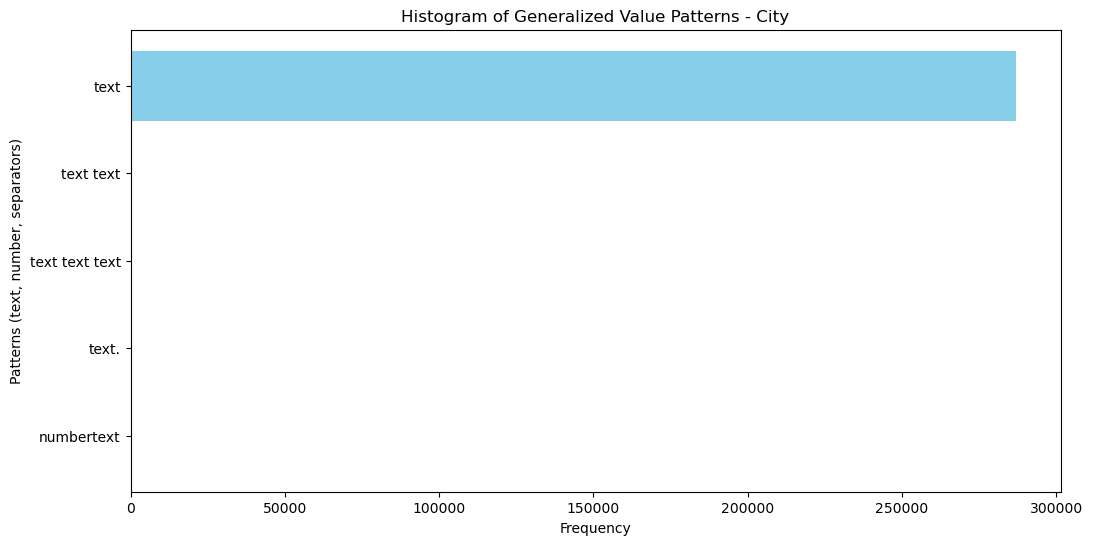

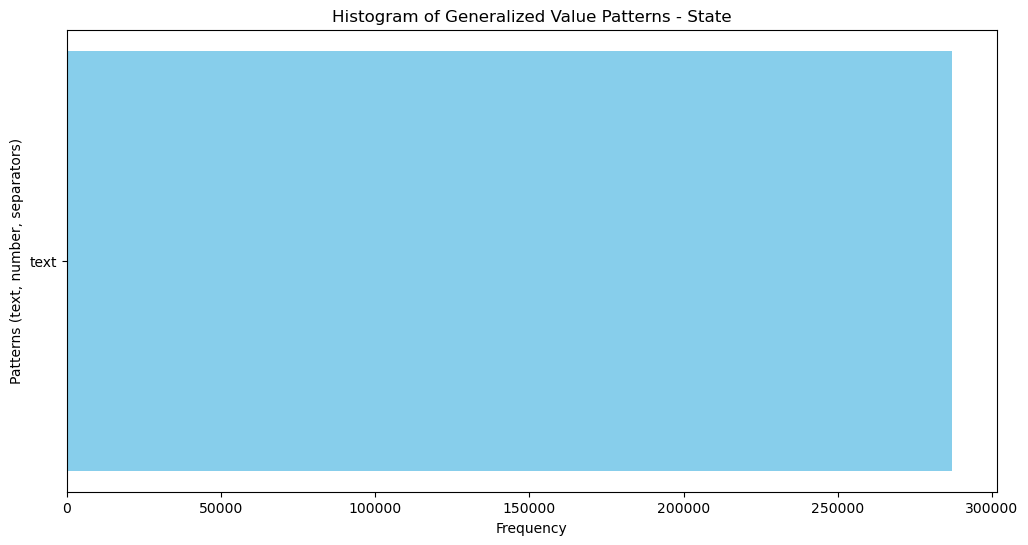

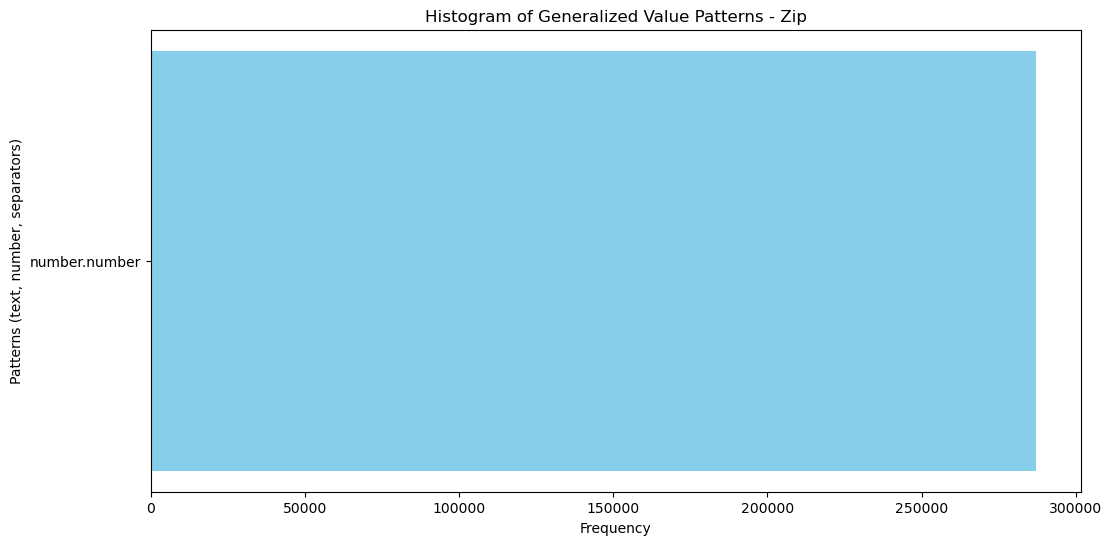

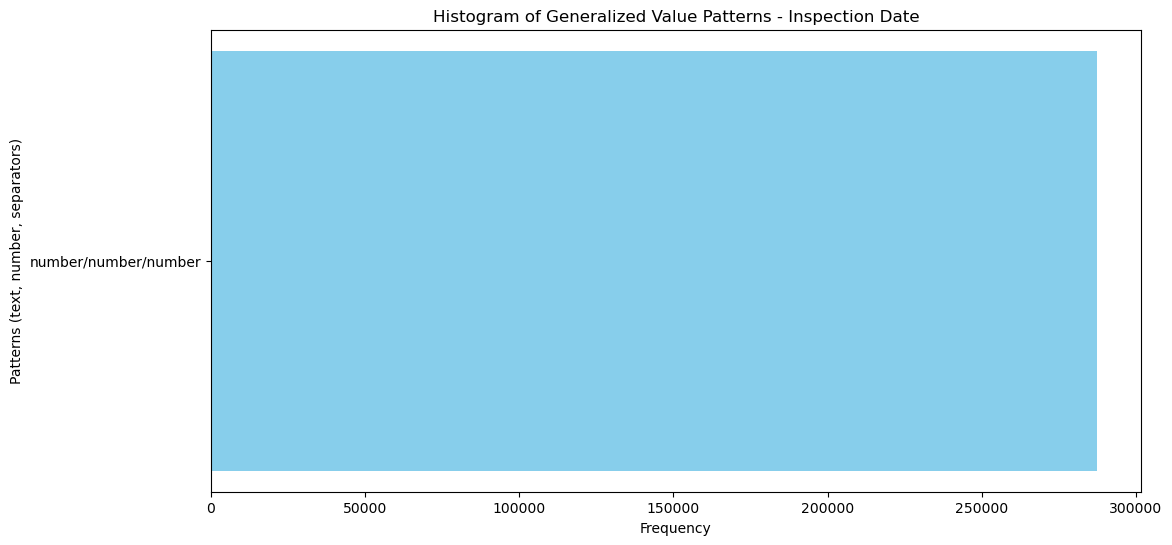

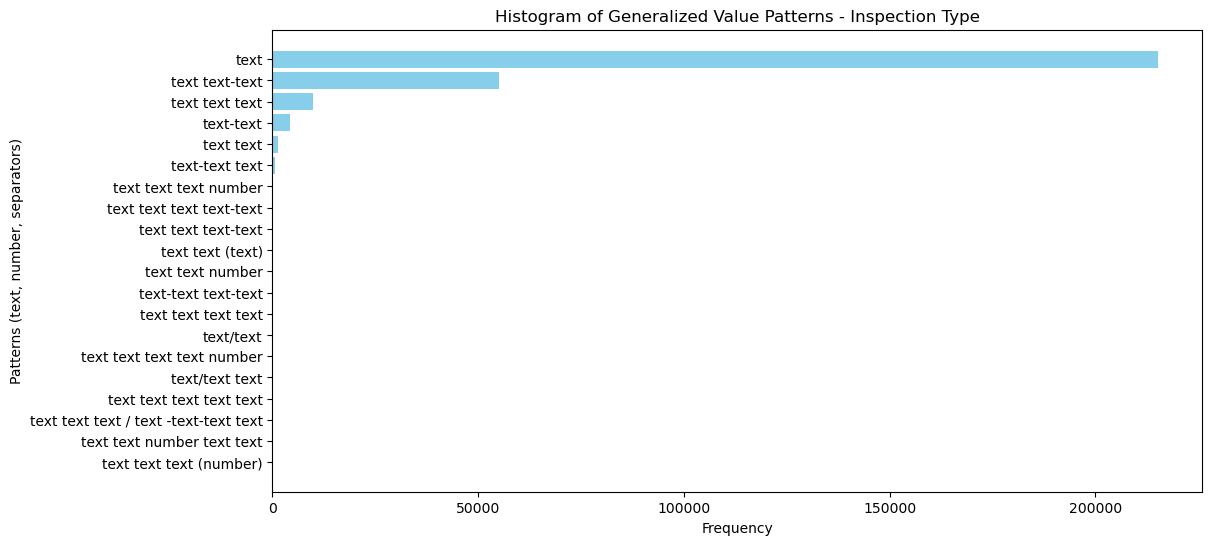

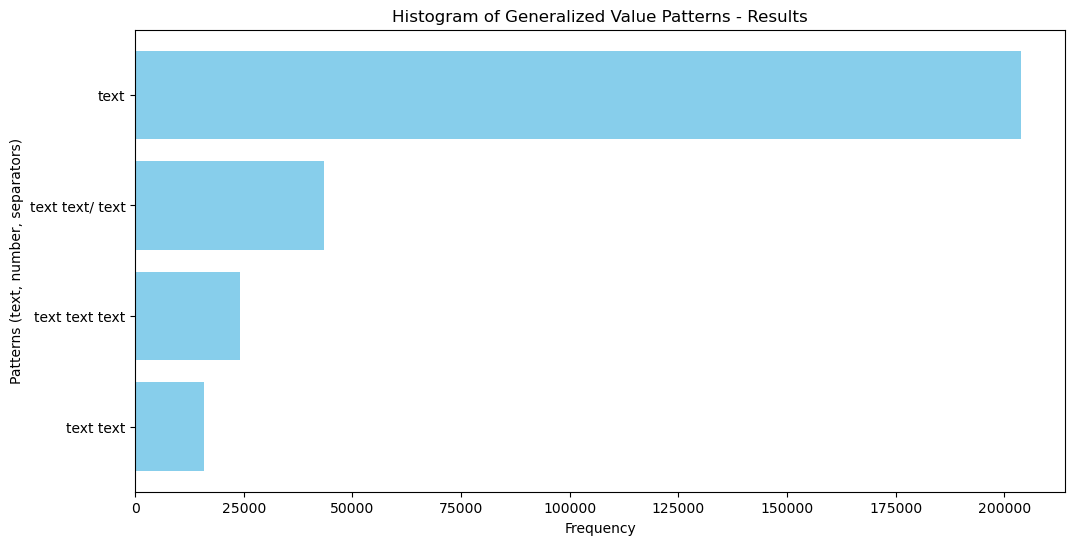

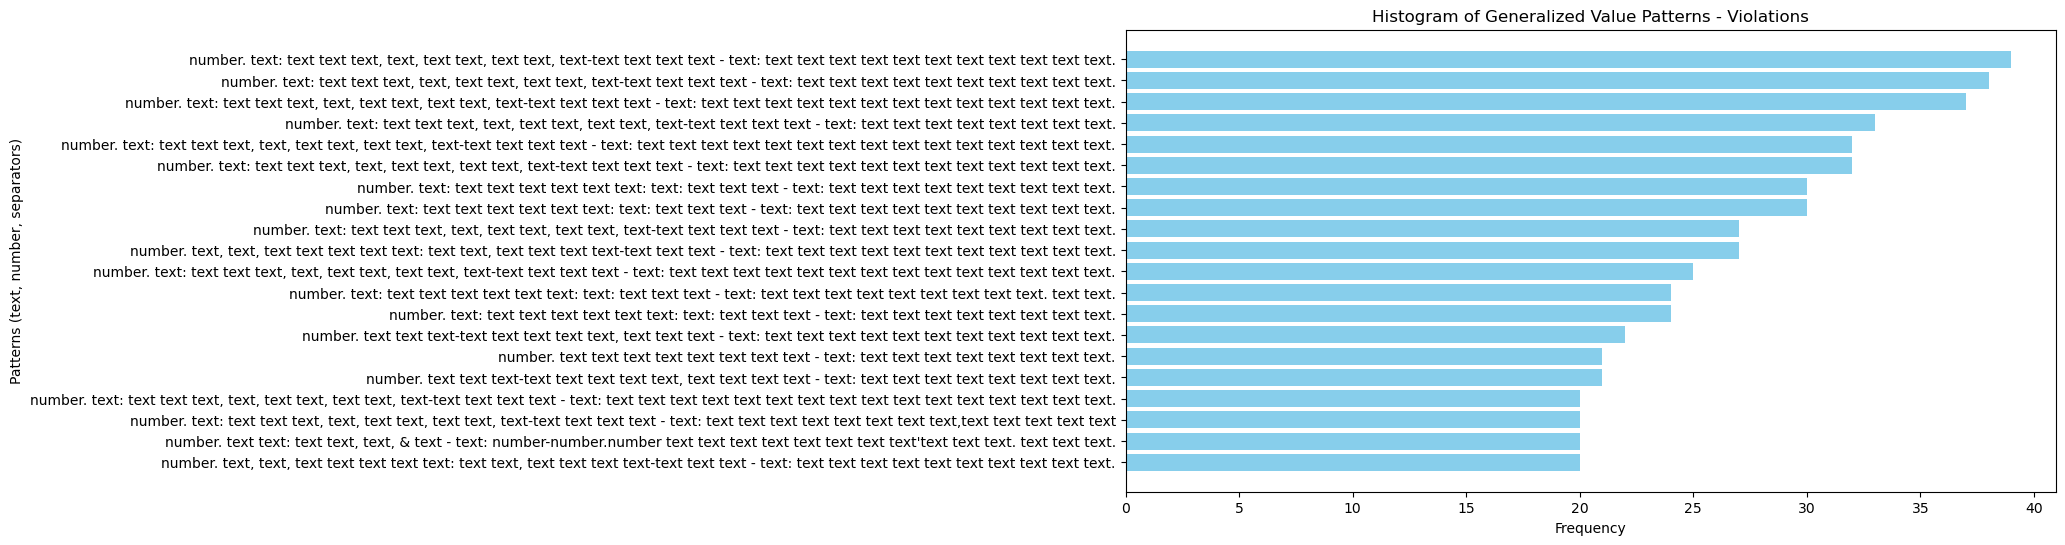

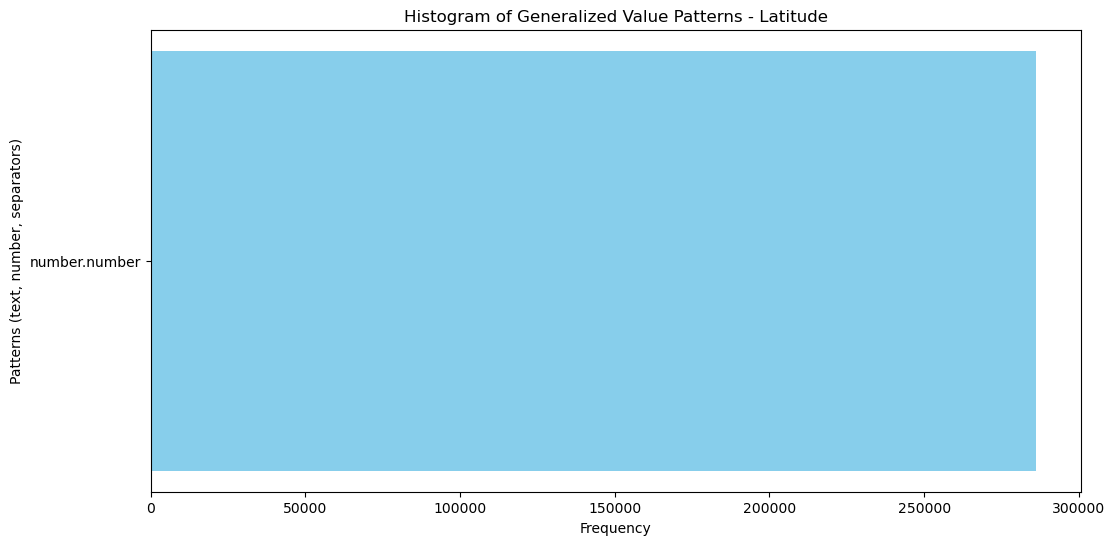

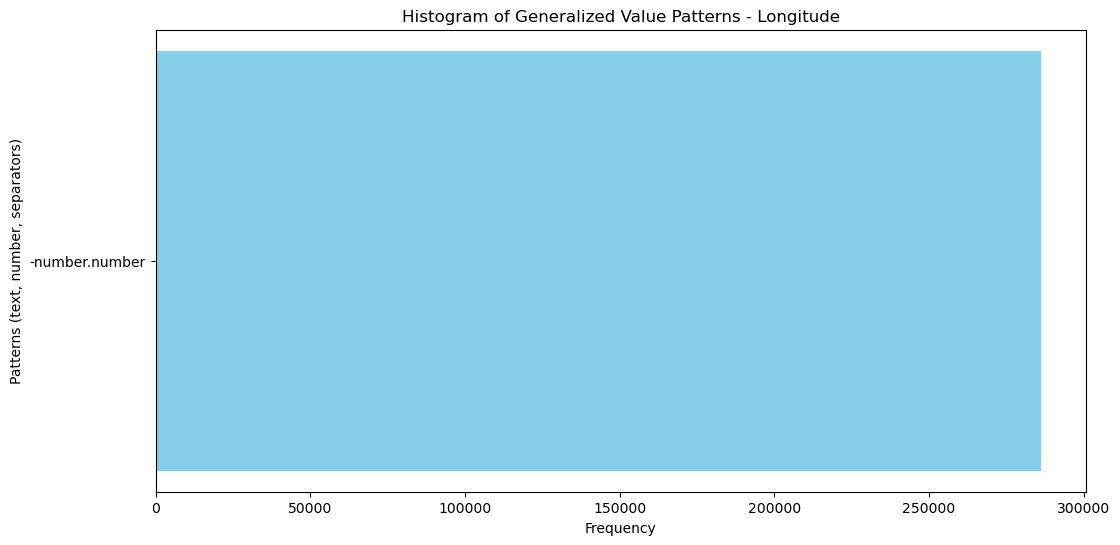

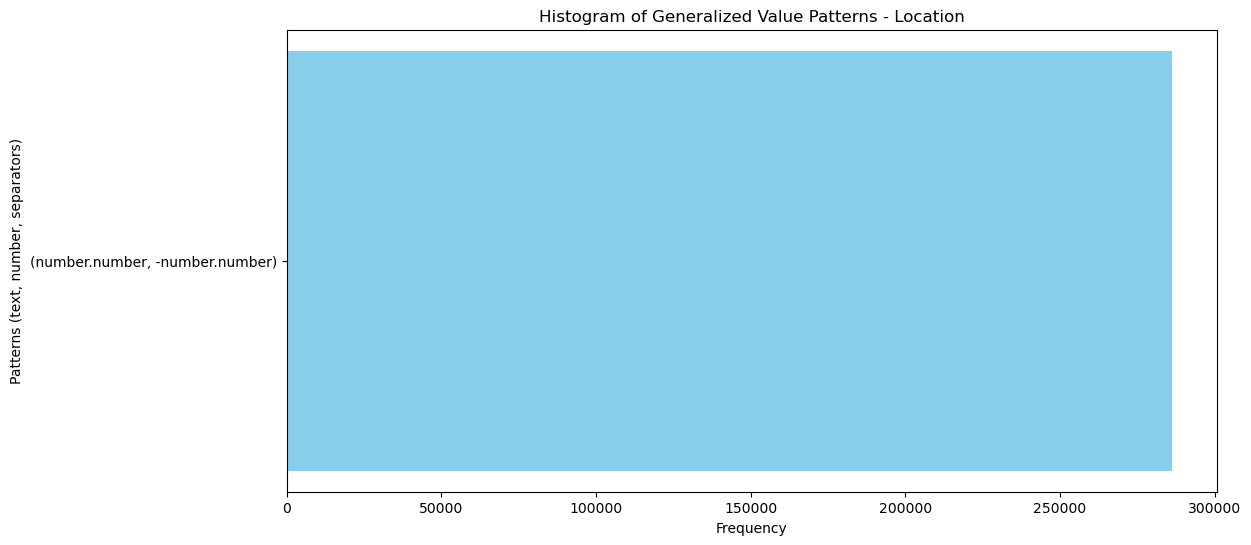

In [36]:
# Function to determine generalized value patterns (text, number, special characters as separators)
def detect_generalized_pattern(value):
    if pd.isna(value):
        return "Missing"
    value = str(value)

    # Replace sequences of uppercase/lowercase letters with "text"
    value = re.sub(r'[A-Za-z]+', 'text', value)

    # Replace sequences of digits with "number"
    value = re.sub(r'\d+', 'number', value)

    return value  # Keeps special characters as separators

# Profiling results for patterns
patterns_results = []
pattern_counts = {}
column_pattern_summary = []  # To store number of patterns per column

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue

    # Identify generalized patterns
    patterns = col_data.map(detect_generalized_pattern).value_counts().to_dict()

    for pattern, count in patterns.items():
        if pattern in pattern_counts:
            pattern_counts[pattern] += count
        else:
            pattern_counts[pattern] = count

    # Store pattern count summary for the column
    column_pattern_summary.append({"Column": column, "Total Unique Patterns": len(patterns)})

    patterns_results.append({
        "Column": column,
        "Patterns": patterns
    })

# Save the number of patterns in each column to a CSV file
summary_df = pd.DataFrame(column_pattern_summary)
summary_file_path = "column_pattern_summary.csv"
summary_df.to_csv(summary_file_path, index=False)
print(f"Pattern summary saved in {summary_file_path}")

# Create a directory to save histograms
output_dir = "column_pattern_histograms"
os.makedirs(output_dir, exist_ok=True)

# Generate histogram for each column
histogram_files = []
for result in patterns_results:
    column = result["Column"]
    patterns = result["Patterns"]

    if not patterns:
        continue

    # Convert dictionary to sorted list
    sorted_patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
    pattern_labels, pattern_counts = zip(*sorted_patterns[:20])  # Show top 20 patterns

    # Plot histogram
    plt.figure(figsize=(12, 6))
    plt.barh(pattern_labels, pattern_counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.ylabel("Patterns (text, number, separators)")
    plt.title(f"Histogram of Generalized Value Patterns - {column}")
    plt.gca().invert_yaxis()  # Invert y-axis to show highest count on top






In [19]:
# Profiling results
data_classes_results = []

for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue
    
    # Identify data class
    data_classes = col_data.map(classify_data_class).value_counts().to_dict()

    data_classes_results.append({
        "Column": column,
        "Data Class": data_classes
    })

In [20]:
data_classes_results

[{'Column': 'Inspection ID', 'Data Class': {'Code/Identifier': 287237}},
 {'Column': 'DBA Name',
  'Data Class': {'Text': 148875, 'Other': 115638, 'Code/Identifier': 22724}},
 {'Column': 'AKA Name',
  'Data Class': {'Text': 155153, 'Other': 102770, 'Code/Identifier': 26888}},
 {'Column': 'License #', 'Data Class': {'Quantity': 287219}},
 {'Column': 'Facility Type',
  'Data Class': {'Code/Identifier': 222218, 'Text': 43702, 'Other': 16120}},
 {'Column': 'Risk', 'Data Class': {'Other': 287081, 'Code/Identifier': 68}},
 {'Column': 'Address', 'Data Class': {'Other': 287234, 'Text': 3}},
 {'Column': 'City',
  'Data Class': {'Code/Identifier': 286992, 'Text': 74, 'Other': 7}},
 {'Column': 'State', 'Data Class': {'Code/Identifier': 287179}},
 {'Column': 'Zip', 'Data Class': {'Quantity': 287198}},
 {'Column': 'Inspection Date', 'Data Class': {'Date/Time': 287237}},
 {'Column': 'Inspection Type',
  'Data Class': {'Code/Identifier': 215245, 'Other': 60792, 'Text': 11199}},
 {'Column': 'Results',

In [21]:
# Profiling results
domains_results = []
for column in df.columns:
    col_data = df[column].dropna()
    if col_data.empty:
        continue
    
    # Identify domain classification
    domains = col_data.map(classify_domain).value_counts().to_dict()

    domains_results.append({
        "Column": column,
        "Domain": domains
    })


In [22]:
domains_results

[{'Column': 'Inspection ID',
  'Domain': {'Unknown': 283947, 'Postal Code': 3290}},
 {'Column': 'DBA Name', 'Domain': {'Unknown': 287232, 'Postal Code': 5}},
 {'Column': 'AKA Name', 'Domain': {'Unknown': 284811}},
 {'Column': 'License #', 'Domain': {'Unknown': 287219}},
 {'Column': 'Facility Type', 'Domain': {'Unknown': 282040}},
 {'Column': 'Risk', 'Domain': {'Unknown': 287149}},
 {'Column': 'Address', 'Domain': {'Unknown': 287237}},
 {'Column': 'City', 'Domain': {'Unknown': 286625, 'City': 448}},
 {'Column': 'State', 'Domain': {'Unknown': 287179}},
 {'Column': 'Zip', 'Domain': {'Unknown': 287198}},
 {'Column': 'Inspection Date', 'Domain': {'Unknown': 287237}},
 {'Column': 'Inspection Type', 'Domain': {'Unknown': 287236}},
 {'Column': 'Results', 'Domain': {'Unknown': 287237}},
 {'Column': 'Violations', 'Domain': {'Unknown': 207585}},
 {'Column': 'Latitude', 'Domain': {'Unknown': 286259}},
 {'Column': 'Longitude', 'Domain': {'Unknown': 286259}},
 {'Column': 'Location', 'Domain': {'Unkn